In [2]:
from Codes import Model, Focal_Loss, Dataset, train_func, evaluation_func
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import os

In [3]:
folder = "results"
try:
    os.mkdir(folder)
except:
    pass

# Prepare data

In [4]:
metadata_folder = '../metadata/'
clinical = pd.read_table(metadata_folder+'clinical.tsv', encoding='utf-8', index_col=1)
clinical = clinical[~clinical.index.duplicated(keep='first')]

manifest = pd.read_table(metadata_folder+'gdc_manifest_tissue_images.txt')
files = "Data/" + manifest['id'] + '/' + manifest['filename']
clinical_gdc = pd.read_table(metadata_folder+'nationwidechildrens.org_clinical_patient_ov.txt', index_col=1).iloc[2:]

def cs_to_int(cs):
    match cs:
        case "Stage IA":
            return 1
        case "Stage IB":
            return 1
        case 'Stage IC':
            return 1
        case 'Stage IIA':
            return 2
        case 'Stage IIB':
            return 2
        case 'Stage IIC':
            return 2
        case 'Stage IIIA':
            return 3
        case 'Stage IIIB':
            return 3
        case 'Stage IIIC':
            return 3
        case 'Stage IV':
            return 4
        case '[Not Available]':
            return 3
clinical_gdc['clinical_stage'] = clinical_gdc['clinical_stage'].apply(cs_to_int)
manifest['case.id'] = manifest['filename'].apply(lambda x: x[:12])

In [5]:
def get_cBioportal_survival(pfs_path, os_path, dfs_path, dss_path):
    data_pfs = pd.read_table(pfs_path, index_col=1, header=0).dropna()
    data_os = pd.read_table(os_path, index_col=1, header=0).dropna()
    data_dfs = pd.read_table(dfs_path, index_col=1, header=0).dropna()
    data_dss = pd.read_table(dss_path, index_col=1, header=0).dropna()

    data_pfs = data_pfs[~data_pfs.index.duplicated(keep="first")]
    data_pfs["PFS_STATUS"] = [s[0] for s in data_pfs["PFS_STATUS"]]
    data_os["OS_STATUS"] = [s[0] for s in data_os["OS_STATUS"]]
    data_dfs["DFS_STATUS"] = [s[0] for s in data_dfs["DFS_STATUS"]]
    data_dss["DSS_STATUS"] = [s[0] for s in data_dss["DSS_STATUS"]]
    data_dfs = data_dfs[~data_dfs.index.duplicated(keep="first")]
    data_dss = data_dss[~data_dss.index.duplicated(keep="first")]
    data_pfs = data_pfs[~data_pfs.index.duplicated(keep="first")]
    data_os = data_os[~data_os.index.duplicated(keep="first")]
    return data_pfs, data_os, data_dfs, data_dss

pfs_path = metadata_folder+"KM_Plot__Progression_Free__Survival_(months)_pancancer.txt"
os_path = metadata_folder+"KM_Plot__Overall_Survival__(months)_pancancer.txt"
dfs_path = metadata_folder+"KM_Plot__Disease_Free__Survival_(months)_pancancer.txt"
dss_path = metadata_folder+"KM_Plot__Disease-specific_Survival__(months)_pancancer.txt"
ov_pfs, ov_os, ov_dfs, ov_dss = get_cBioportal_survival(pfs_path, os_path, dfs_path, dss_path)

In [6]:
manifest_pfs = manifest.join(ov_pfs, on='case.id', how='inner')
manifest_pfs = manifest_pfs[manifest_pfs['PFS_STATUS']=='1']
patients = manifest_pfs.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')
patients_s1and2 = patients[(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==2)|(patients['clinical_stage']==2)].index
manifest_pfs = manifest_pfs[[p not in patients_s1and2 for p in manifest_pfs['case.id']]]

manifest_os = manifest.join(ov_os, on='case.id', how='inner')
manifest_os = manifest_os[manifest_os['OS_STATUS']=='1']
patients = manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')
patients_s1and2 = patients[(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==1)|(patients['clinical_stage']==2)|(patients['clinical_stage']==2)].index
manifest_os = manifest_os[[p not in patients_s1and2 for p in manifest_os['case.id']]]

In [7]:
manifest_os[["OS_MONTHS"]].median()

OS_MONTHS    35.12
dtype: float64

In [8]:
manifest_pfs[['PFS_MONTHS']].median()

PFS_MONTHS    14.794358
dtype: float64

In [9]:
clinical_features = manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner').columns[1:]
print('Median diagnostic age in months:', manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')['age_at_initial_pathologic_diagnosis'].astype(int).median())

for c in clinical_features:
    print(manifest_os.set_index('case.id').groupby(level=0).first().join(clinical_gdc,how='inner')[['id',c]].groupby(c).count())

Median diagnostic age in months: 60.0
                                                    id
filename                                              
TCGA-04-1331-01A-01-BS1.27aaf831-a80b-4a55-a239...   1
TCGA-04-1332-01A-01-BS1.0f52bd8b-65e8-4648-b6b8...   1
TCGA-04-1337-01A-01-TS1.fcf8e211-01f7-4937-b0b1...   1
TCGA-04-1342-01A-01-TS1.66421418-fc94-4215-9ab1...   1
TCGA-04-1343-01A-01-BS1.ffc80a0b-db70-456c-8e52...   1
...                                                 ..
TCGA-61-2611-11A-01-TS1.1e7c1593-3fc9-4ee1-880d...   1
TCGA-61-2612-01A-01-TS1.99d37374-5619-4342-86df...   1
TCGA-61-2613-01A-01-BS1.a03e1b6b-eb1f-4956-8ed9...   1
TCGA-61-2614-01A-01-TS1.9649012a-36a2-4680-9198...   1
TCGA-WR-A838-01A-01-TS1.E8CA96CD-A253-4090-86BA...   1

[335 rows x 1 columns]
                                  id
md5                                 
00a9e933de8248013b246eacbc401a40   1
0121655fd45a5ebb08a166b38f2eb8f3   1
016bd9a4a485515b49b32d5e2f699890   1
0219af3fac02cb8474115c62f415defd   1
0

In [10]:
y_os = (manifest_os[["OS_MONTHS"]]>=36).map(lambda x: 1 if x else 0)
manifest_os['y'] = y_os

image_folder = '../Data/'
files = (image_folder + manifest_os["id"] + '/' + manifest_os["filename"] + "-1.jpg").values
X_train, X_test, y_train, y_test = train_test_split(files, manifest_os['y'], random_state=0)
print("Total number of image:", len(files))
train_dataset = Dataset.MyData_test(X_train, y_train)
train_dataloader = DataLoader(train_dataset,batch_size=1,shuffle=False)
# 5-fold CV with X_train/y_train
cv_files = {}
dataset_sizes = {}
kf = KFold(n_splits=5, random_state=0, shuffle=True)
for i, (train_index, val_index) in enumerate(kf.split(X_train)):
    # Double training dataset with cropped and augmented images
    manifest_os.loc[y_train.iloc[train_index].index].to_csv(f'training_fold_{i}.csv')
    print(f"Fold {i} train data: {len(train_index)}, val data: {len(val_index)}")
    train_file_2 = [file.replace('-1.jpg', '-2.jpg') for file in X_train[train_index]]
    X_train_double = np.concatenate([X_train[train_index], train_file_2])
    y_fold_train = y_train.iloc[train_index]
    y_train_double = pd.concat([y_fold_train, y_fold_train])
    X_val = X_train[val_index]
    y_val =y_train.iloc[val_index]
    train_dataset = Dataset.MyData_train(X_train_double, y_train_double)
    val_dataset = Dataset.MyData_test(X_val, y_val)
    cv_files[i] = {'train': DataLoader(train_dataset,batch_size=6,shuffle=True,pin_memory=True), 'val': DataLoader(val_dataset,batch_size=3,shuffle=False,pin_memory=True)}
    dataset_sizes[i] = {'train': len(train_dataset), 'val': len(val_dataset)}
# Testing data with X_test/y_test
print(f"Test data: {len(X_test)}")
manifest_os.loc[y_test.index].to_csv(f'testing.csv')
test_dataset = Dataset.MyData_test(X_test, y_test)
test_dataloader = DataLoader(test_dataset,batch_size=1,shuffle=False)

Total number of image: 773
Fold 0 train data: 463, val data: 116
Fold 1 train data: 463, val data: 116
Fold 2 train data: 463, val data: 116
Fold 3 train data: 463, val data: 116
Fold 4 train data: 464, val data: 115
Test data: 194


In [11]:
len(np.unique(manifest_os.loc[y_train.index]['case.id'].values))

317

In [12]:
len(np.unique(manifest_os.loc[y_test.index]['case.id'].values))

162

In [13]:
len(set(np.unique(manifest_os.loc[y_train.index]['case.id'].values)).intersection(np.unique(manifest_os.loc[y_test.index]['case.id'].values)))

144

# Training

In [14]:
model_ft = Model.Net()

optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0002)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Save initial model
torch.save({
            'model_state_dict': model_ft.state_dict(),
            'optimizer_state_dict': optimizer_ft.state_dict(),
            }, folder+"/model_initial.pt")

criterion = Focal_Loss.Focal_Loss()

In [ ]:
train_func.train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10, folder=folder, folds=[0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4,0,1,2,3,4], cv_files=cv_files,dataset_sizes=dataset_sizes)

# Evaluation

In [16]:
tcga_train_df = evaluation_func.evaluate_5CV(train_dataloader, y_train.index, folds=[0,1,2,3,4], folder=folder)
tcga_train_df

Fold 0 model: epoch_09loss0.039871_AUROC_0.704545.pt
Fold 0 AUROC: 0.7459642651849012
Fold 1 model: epoch_09loss0.041579_AUROC_0.687184.pt
Fold 1 AUROC: 0.7893993102126844
Fold 2 model: epoch_03loss0.043594_AUROC_0.628121.pt
Fold 2 AUROC: 0.7131634412722743
Fold 3 model: epoch_09loss0.039309_AUROC_0.702508.pt
Fold 3 AUROC: 0.7322283962444913
Fold 4 model: epoch_09loss0.041122_AUROC_0.758620.pt
Fold 4 AUROC: 0.7832199655106342


/media/oscar/b92cef6f-0be0-40dd-9cbd-0950333b5a47/TCGA-OV Tissue Slide/github/Codes/evaluation_func.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["H&E_score"] += cv_predicted_df_dict[fold]["H&E_score"]


H&E_score  gold  layers
102    0.702743   1.0     0.0
1299   0.609272   1.0     0.0
1362   0.694816   1.0     0.0
93     0.452080   0.0     0.0
471    0.587850   0.0     0.0
...         ...   ...     ...
1353   0.468258   0.0     0.0
1365   0.556119   1.0     0.0
670    0.626993   1.0     0.0
551    0.569255   0.0     0.0
803    0.689633   1.0     0.0

[579 rows x 3 columns]

In [18]:
manifest_pfs['PFS_STATUS'] = manifest_pfs['PFS_STATUS'].astype(int)
result_train_score_pfs = manifest_pfs.join(tcga_train_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_pfs = result_train_score_pfs[result_train_score_pfs['PFS_STATUS']==1]
result_train_score_pfs
result_train_score_pfs_clinical = result_train_score_pfs.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

manifest_os['OS_STATUS'] = manifest_os['OS_STATUS'].astype(int)
result_train_score_os = manifest_os.join(tcga_train_df, how='inner')[['case.id','OS_STATUS','OS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_os = result_train_score_os[result_train_score_os['OS_STATUS']==1]
result_train_score_os_clinical = result_train_score_os.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

In [19]:
result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'].astype(int)
result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

In [20]:
manifest_pfs['PFS_STATUS'] = manifest_pfs['PFS_STATUS'].astype(int)
result_train_score_pfs = manifest_pfs.join(tcga_train_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_pfs = result_train_score_pfs[result_train_score_pfs['PFS_STATUS']==1]
result_train_score_pfs
result_train_score_pfs_clinical = result_train_score_pfs.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

manifest_os['OS_STATUS'] = manifest_os['OS_STATUS'].astype(int)
result_train_score_os = manifest_os.join(tcga_train_df, how='inner')[['case.id','OS_STATUS','OS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_train_score_os = result_train_score_os[result_train_score_os['OS_STATUS']==1]
result_train_score_os_clinical = result_train_score_os.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')

result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis'].astype(int)
result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'] = result_train_score_os_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

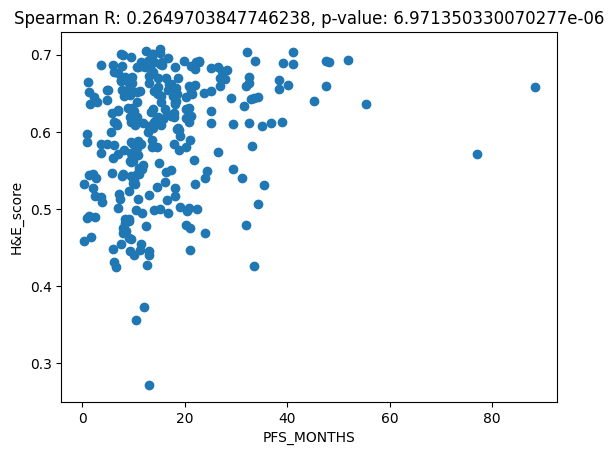

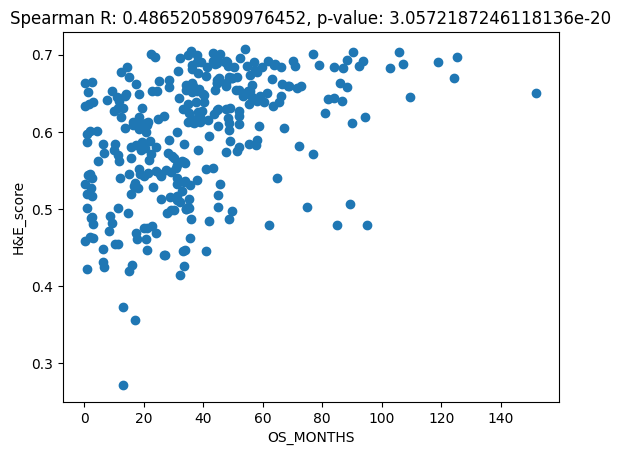

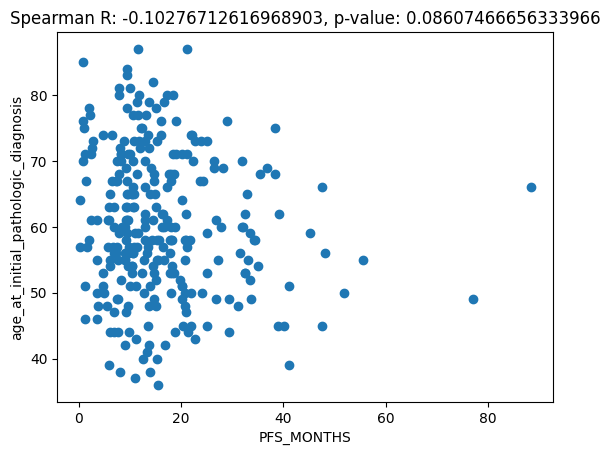

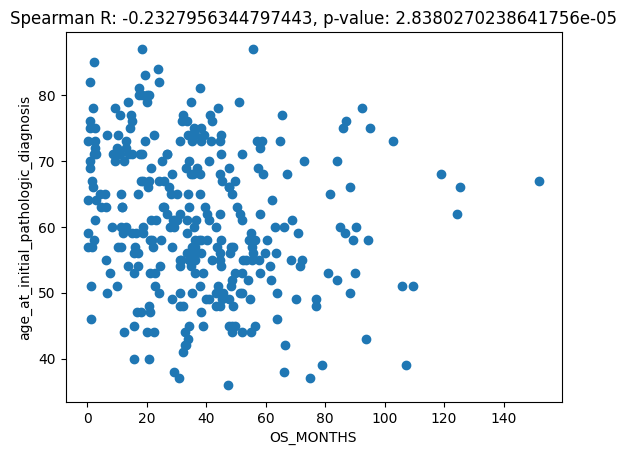

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

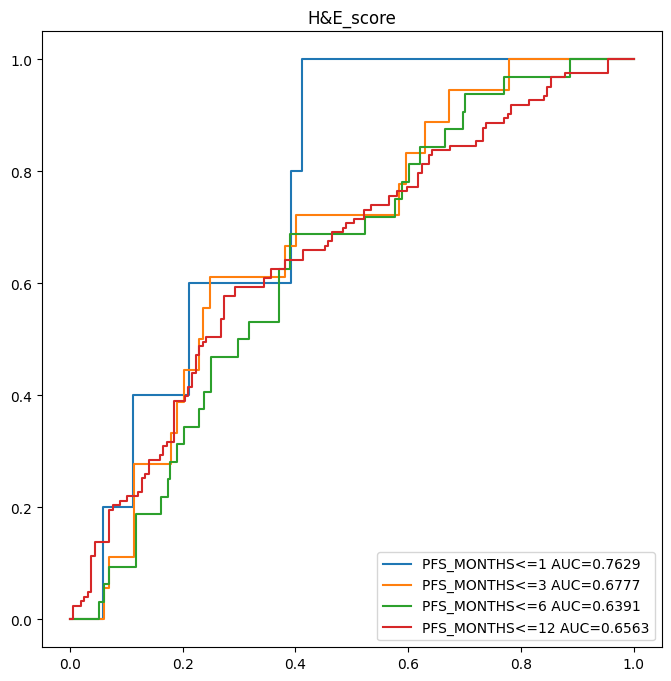

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

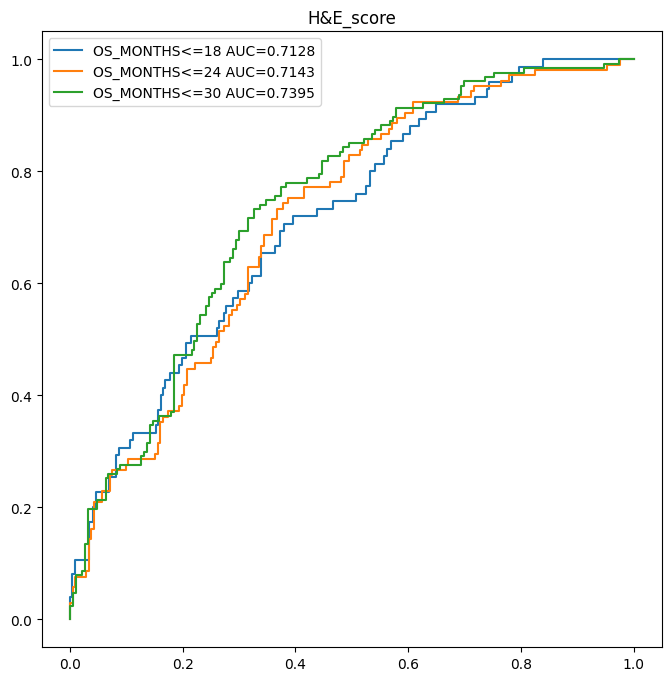

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

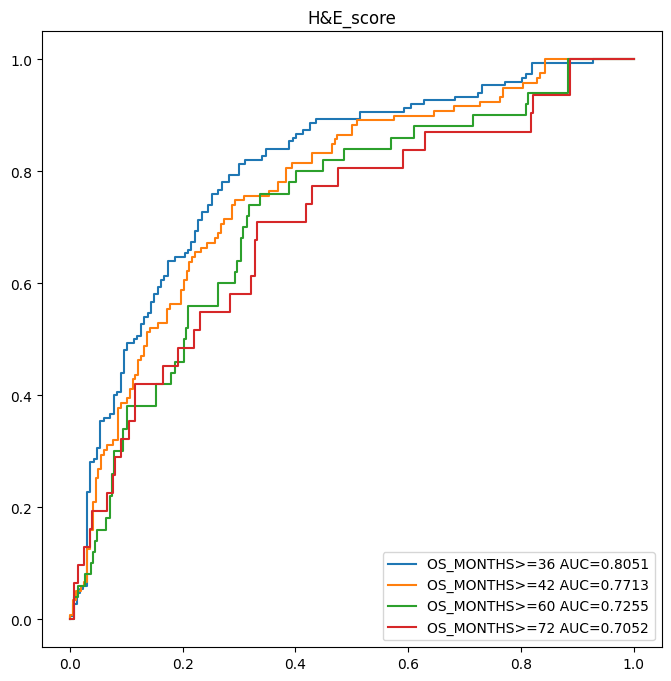

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

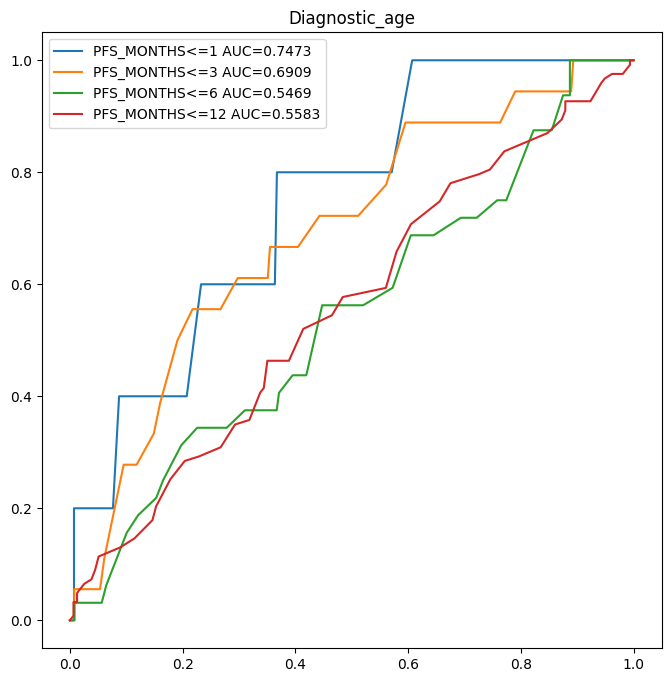

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

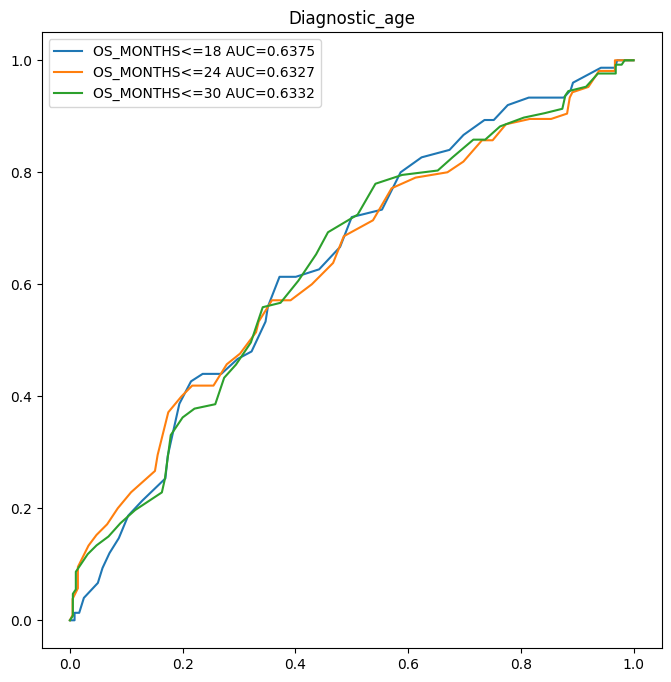

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

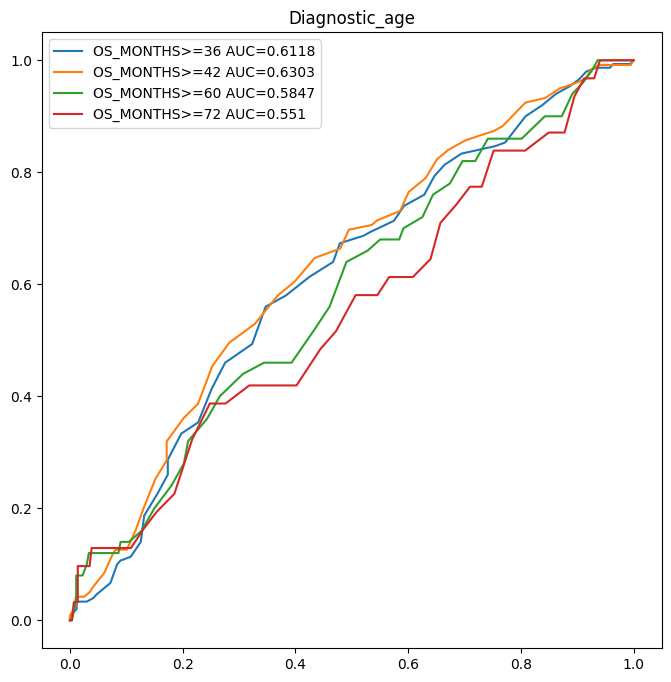

<lifelines.CoxPHFitter: fitted with 317 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 317
number of events observed = 317
   partial log-likelihood = -1477.04
         time fit was run = 2023-11-30 06:36:06 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
H&E_score                            -5.93       0.00       0.71            -7.32            -4.54                 0.00                 0.01
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.02                 1.00                 1.02

                                      cmp to     z      p   -log2(p)
covariate                                                           
H&E_score                               0.00 -8.34 <0.005      53.58
age_at_initial_pathologic_diagnosis     0.00  2.35   0.02       5.73
---
Concordance = 0.68
Partial AIC = 2958.09
log-likelihood ratio test = 70.65 on 2 df
-log2(p) of ll-ratio test = 50.97

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
H&E_score                           -5.928746   0.002662  0.710913   
age_at_initial_pathologic_diagnosis  0.012518   1.012597  0.005329   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
H&E_score                                 -7.322110       -4.535383   
age_at_initial_pathologic_diagnosis        0.002073        0.022963   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
H&E_score                                       0.000661             0.010723   
age_at_initial_pathologic_diagnosis             1.002075             1.023229   

                                     cmp to         z             p   -log2(p)  
covariate                   

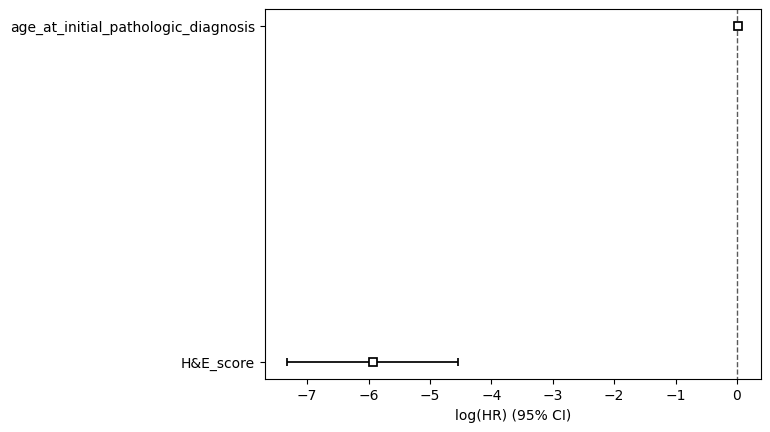

<lifelines.CoxPHFitter: fitted with 280 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 280
number of events observed = 280
   partial log-likelihood = -1289.57
         time fit was run = 2023-11-30 06:36:06 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
H&E_score                            -3.43       0.03       0.75            -4.90            -1.95                 0.01                 0.14
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.02                 1.00                 1.02

                                      cmp to     z      p   -log2(p)
covariate                                                           
H&E_score                               0.00 -4.56 <0.005      17.59
age_at_initial_pathologic_diagnosis     0.00  2.17   0.03       5.08
---
Concordance = 0.59
Partial AIC = 2583.15
log-likelihood ratio test = 23.81 on 2 df
-log2(p) of ll-ratio test = 17.17

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
H&E_score                           -3.426852   0.032489  0.751289   
age_at_initial_pathologic_diagnosis  0.012774   1.012856  0.005874   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
H&E_score                                 -4.899351       -1.954353   
age_at_initial_pathologic_diagnosis        0.001261        0.024287   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
H&E_score                                       0.007451             0.141656   
age_at_initial_pathologic_diagnosis             1.001262             1.024585   

                                     cmp to         z         p   -log2(p)  
covariate                       

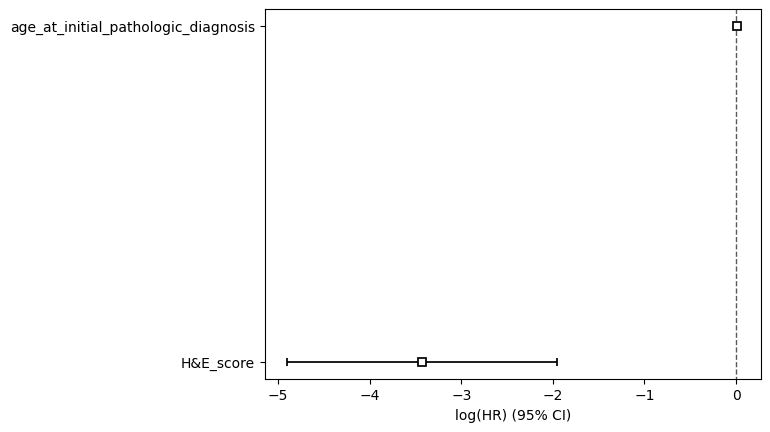

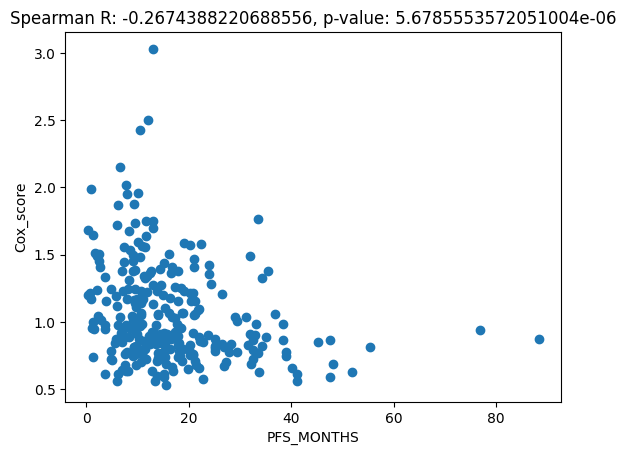

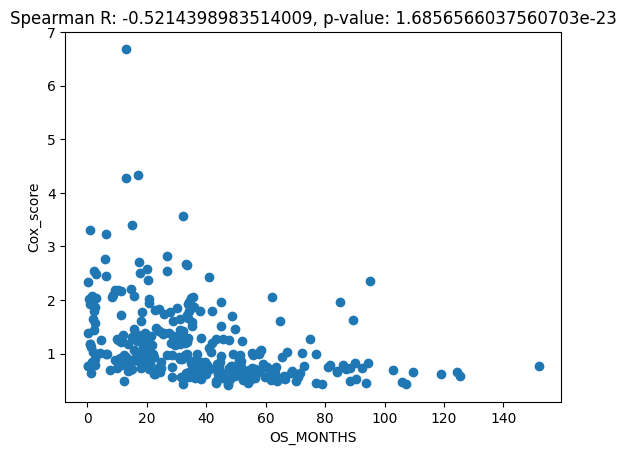

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

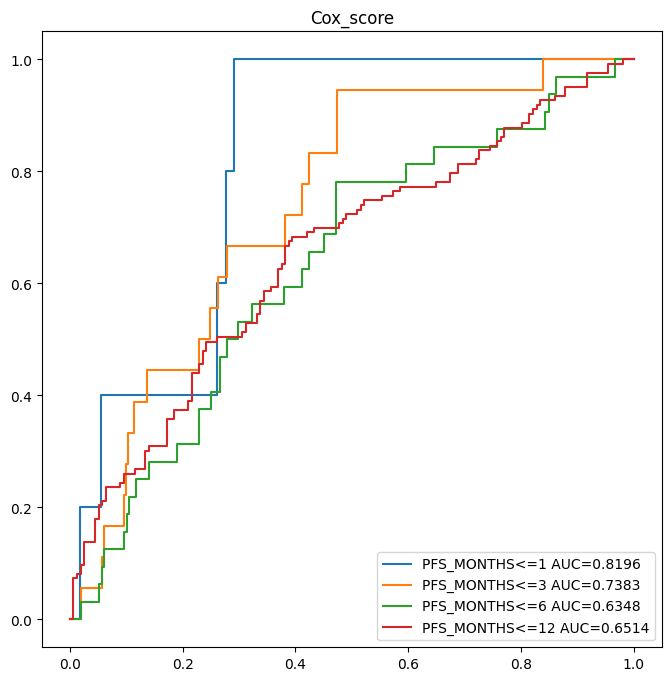

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

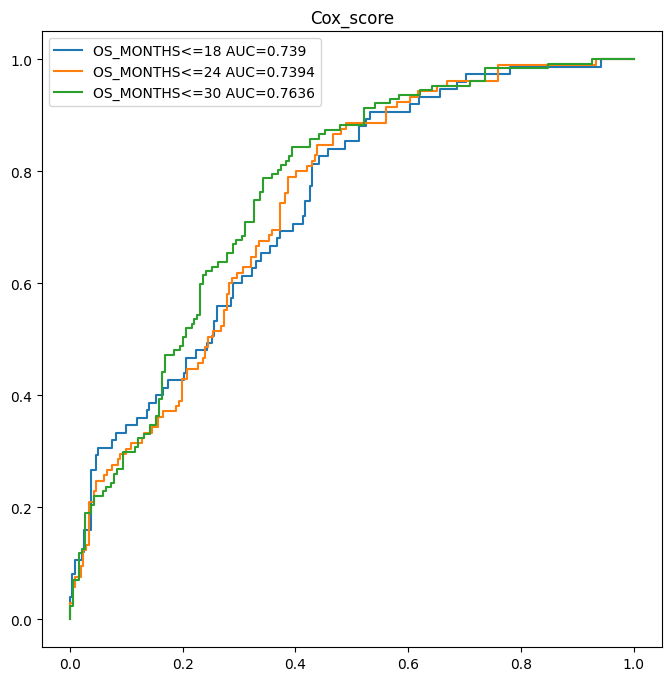

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

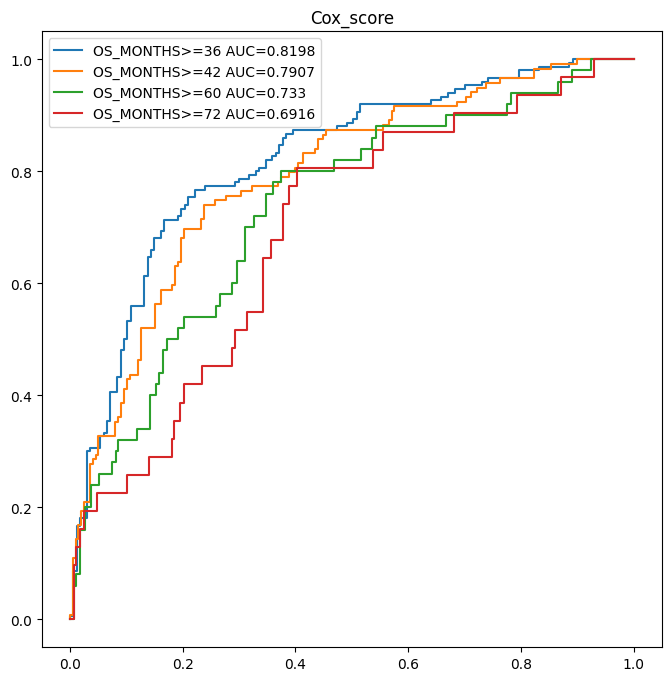

<lifelines.CoxPHFitter: fitted with 280 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 280
number of events observed = 280
   partial log-likelihood = -1289.57
         time fit was run = 2023-11-30 06:36:06 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.02                 1.00                 1.02
H&E_score                            -3.43       0.03       0.75            -4.90            -1.95                 0.01                 0.14

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  2.17   0.03       5.08
H&E_score                               0.00 -4.56 <0.005      17.59
---
Concordance = 0.59
Partial AIC = 2583.15
log-likelihood ratio test = 23.81 on 2 df
-log2(p) of ll-ratio test = 17.17

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.012774   1.012856  0.005874   
H&E_score                           -3.426852   0.032489  0.751289   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.001261        0.024287   
H&E_score                                 -4.899351       -1.954353   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.001262             1.024585   
H&E_score                                       0.007451             0.141656   

                                     cmp to         z         p   -log2(p)  
covariate                       

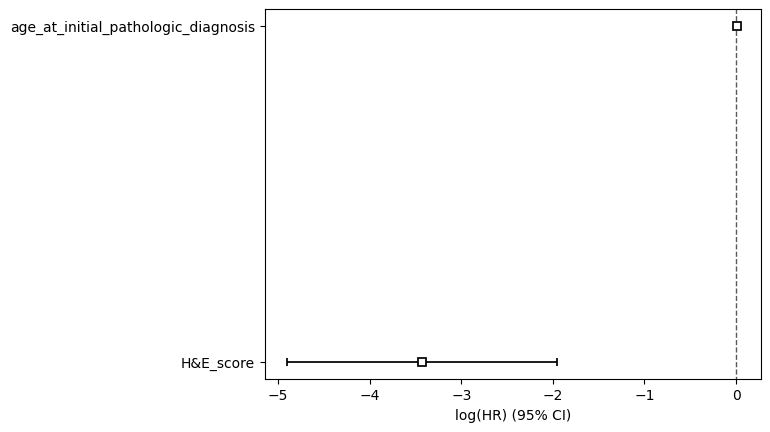

<lifelines.CoxPHFitter: fitted with 317 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 317
number of events observed = 317
   partial log-likelihood = -1477.04
         time fit was run = 2023-11-30 06:36:06 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.02                 1.00                 1.02
H&E_score                            -5.93       0.00       0.71            -7.32            -4.54                 0.00                 0.01

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  2.35   0.02       5.73
H&E_score                               0.00 -8.34 <0.005      53.58
---
Concordance = 0.68
Partial AIC = 2958.09
log-likelihood ratio test = 70.65 on 2 df
-log2(p) of ll-ratio test = 50.97

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.012518   1.012597  0.005329   
H&E_score                           -5.928746   0.002662  0.710913   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.002073        0.022963   
H&E_score                                 -7.322110       -4.535383   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.002075             1.023229   
H&E_score                                       0.000661             0.010723   

                                     cmp to         z             p   -log2(p)  
covariate                   

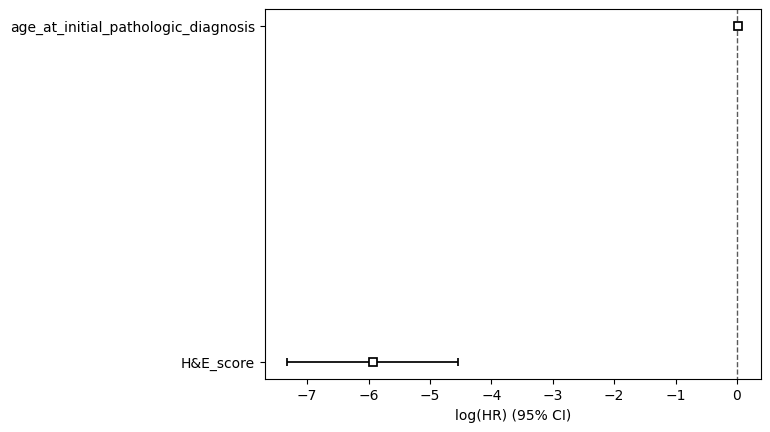

<lifelines.CoxPHFitter: fitted with 317 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 317
number of events observed = 317
   partial log-likelihood = -1479.81
         time fit was run = 2023-11-30 06:36:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -6.04       0.00       0.71            -7.44            -4.65                 0.00                 0.01

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -8.49 <0.005      55.43
---
Concordance = 0.66
Partial AIC = 2961.61
log-likelihood ratio test = 65.13 on 1 df
-log2(p) of ll-ratio test = 50.34

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -6.043264   0.002374  0.711755       -7.438278       -4.648251   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.000588             0.009578     0.0 -8.490656   

                      p   -log2(p)  
covariate                           
H&E_score  2.054732e-17  55.433828  


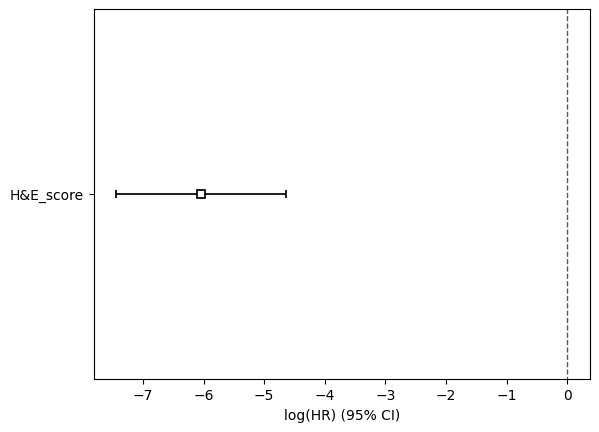

<lifelines.CoxPHFitter: fitted with 280 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 280
number of events observed = 280
   partial log-likelihood = -1291.93
         time fit was run = 2023-11-30 06:36:07 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -3.41       0.03       0.75            -4.88            -1.94                 0.01                 0.14

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -4.55 <0.005      17.49
---
Concordance = 0.59
Partial AIC = 2585.86
log-likelihood ratio test = 19.09 on 1 df
-log2(p) of ll-ratio test = 16.29

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -3.406983   0.033141  0.749198       -4.875384       -1.938582   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.007632             0.143908     0.0 -4.547507   

                  p  -log2(p)  
covariate                      
H&E_score  0.000005  17.49101  


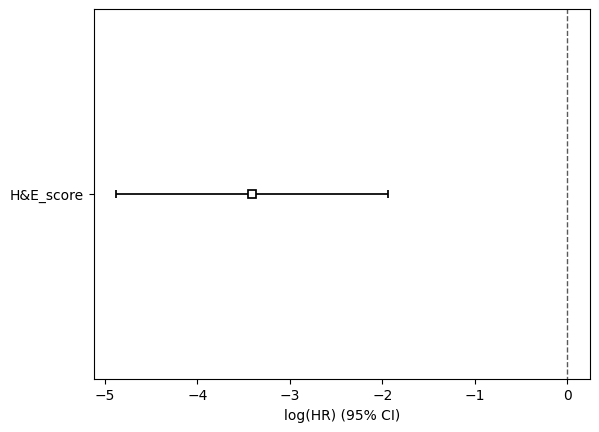

<lifelines.CoxPHFitter: fitted with 317 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 317
number of events observed = 317
   partial log-likelihood = -1508.57
         time fit was run = 2023-11-30 06:36:07 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.02                 1.00                 1.03

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 2.76 0.01       7.43
---
Concordance = 0.58
Partial AIC = 3019.14
log-likelihood ratio test = 7.60 on 1 df
-log2(p) of ll-ratio test = 7.42

                                       coef  exp(coef)  se(coef)  \
covariate                                                          
age_at_initial_pathologic_diagnosis  0.0145   1.014605  0.005258   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.004195        0.024804   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.004204             1.025115   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  2.757894  0.005818  7.425381  


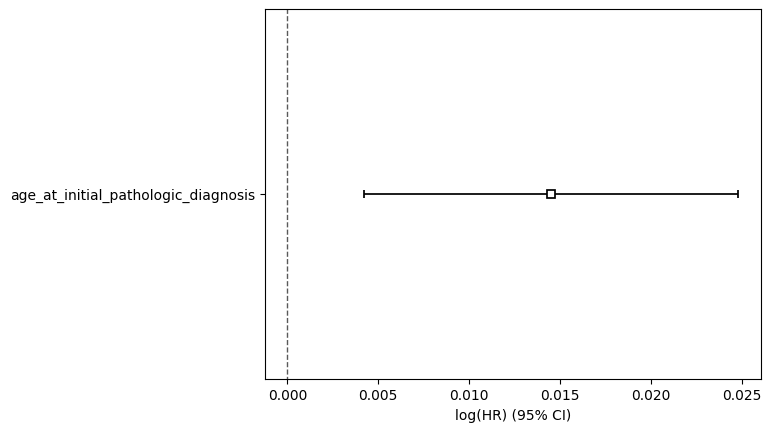

<lifelines.CoxPHFitter: fitted with 280 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 280
number of events observed = 280
   partial log-likelihood = -1299.17
         time fit was run = 2023-11-30 06:36:07 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.02                 1.00                 1.02

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 2.15 0.03       4.99
---
Concordance = 0.53
Partial AIC = 2600.35
log-likelihood ratio test = 4.61 on 1 df
-log2(p) of ll-ratio test = 4.98

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.012412   1.012489  0.005769   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.001106        0.023718   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.001106             1.024002   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  2.151648  0.031425  4.991938  


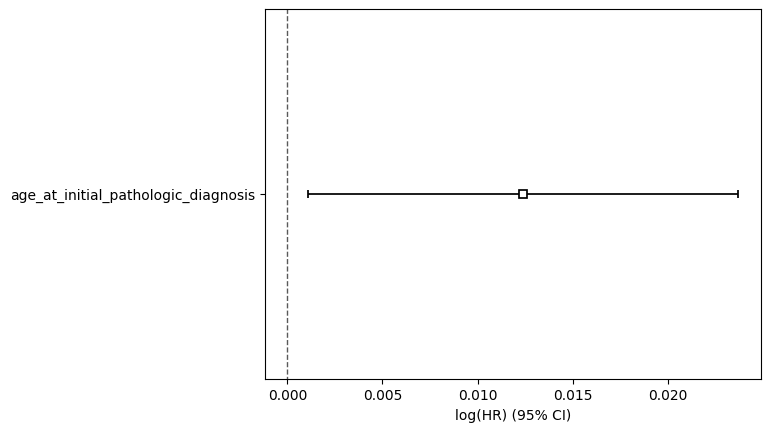

(<lifelines.CoxPHFitter: fitted with 317 total observations, 0 right-censored observations>,
 <lifelines.CoxPHFitter: fitted with 280 total observations, 0 right-censored observations>)

In [21]:
evaluation_func.model_performance(result_train_score_pfs_clinical, result_train_score_os_clinical)

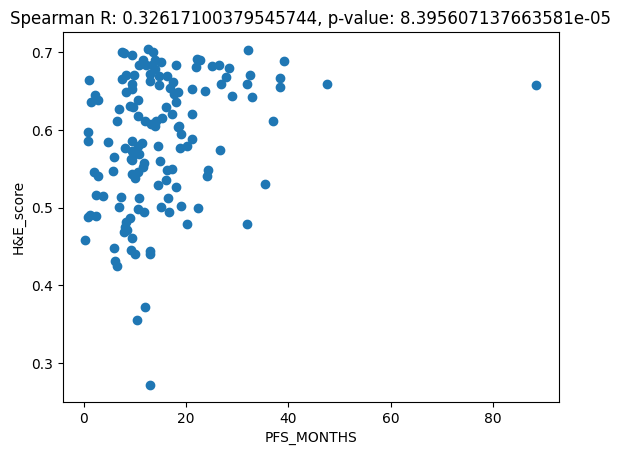

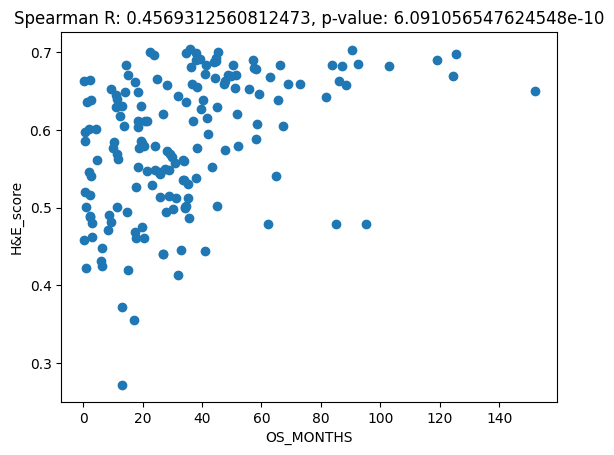

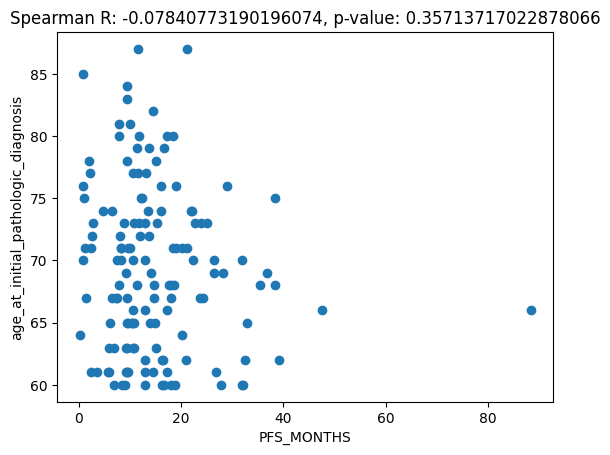

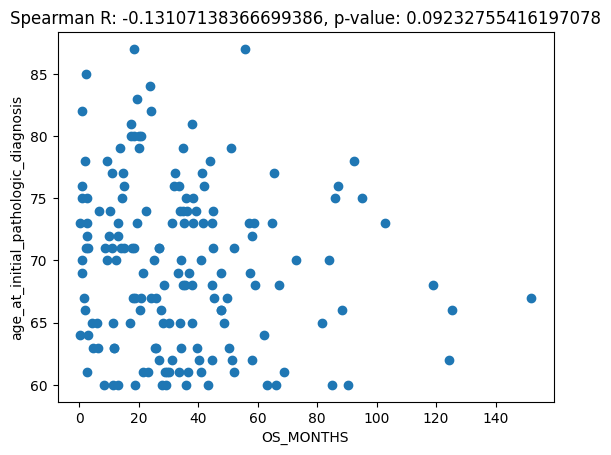

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

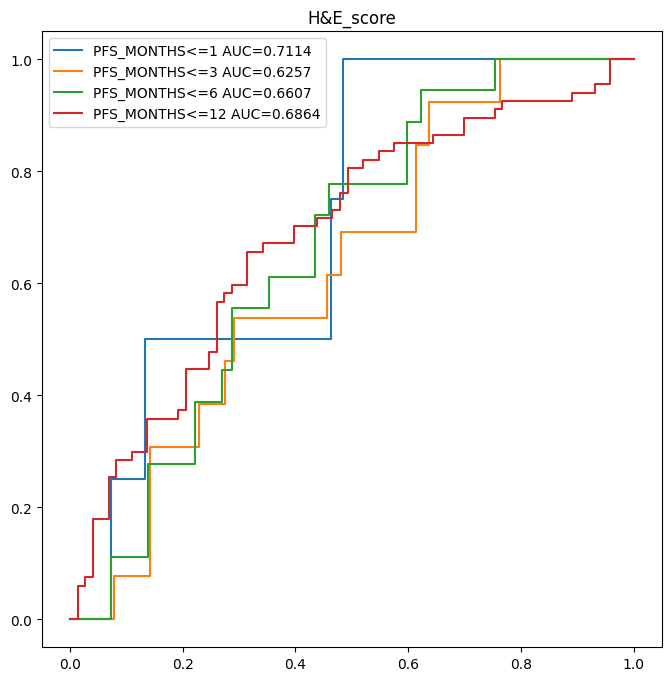

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

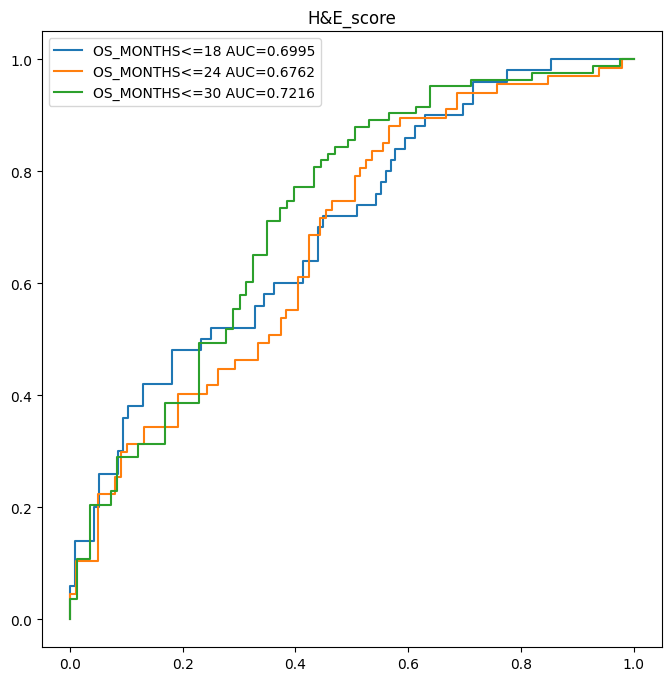

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

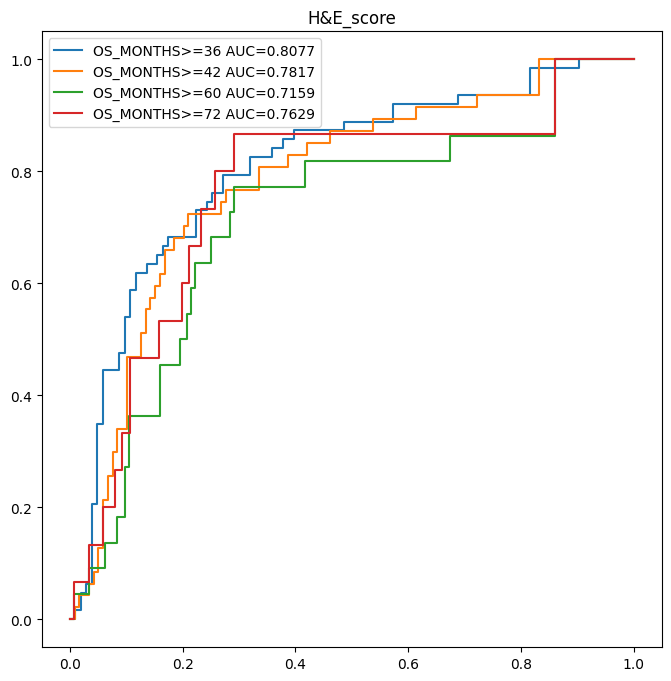

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

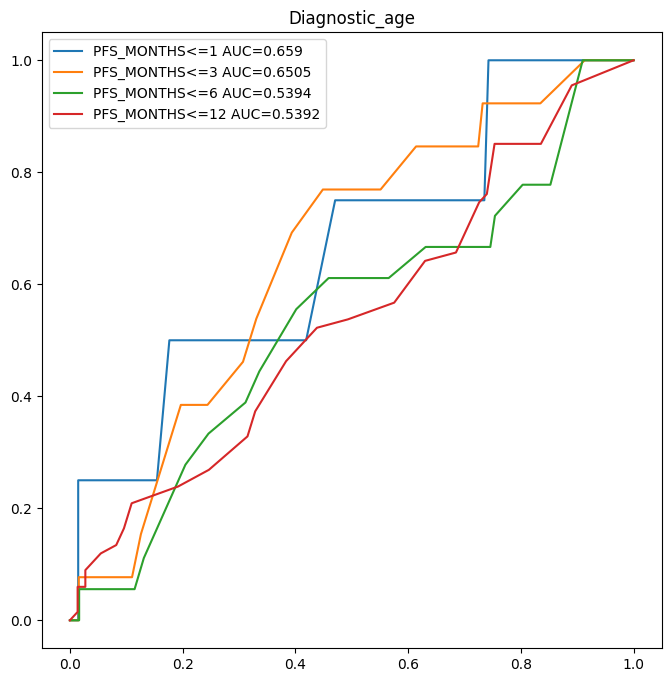

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

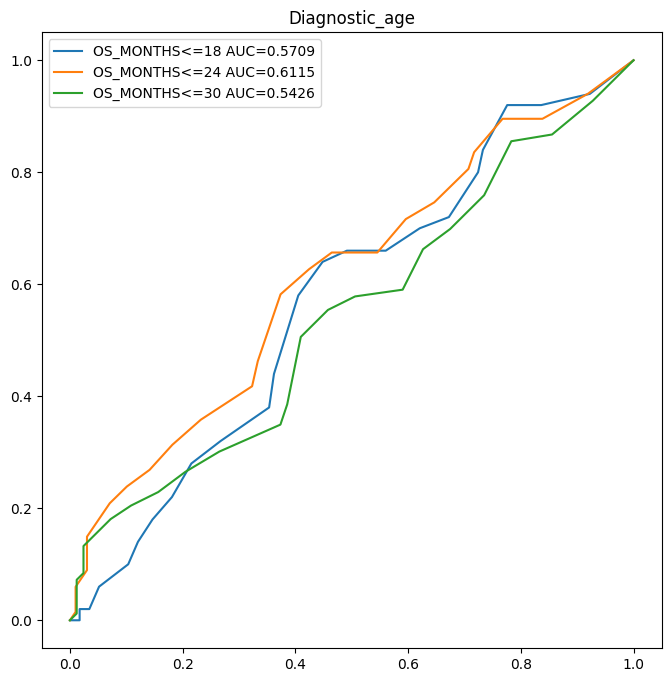

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

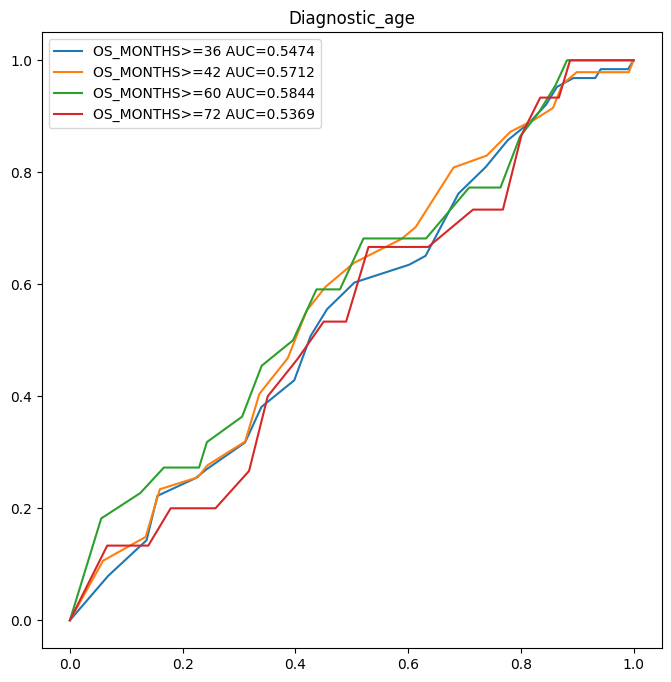

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -667.04
         time fit was run = 2023-11-30 06:36:07 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
H&E_score                            -5.66       0.00       0.91            -7.45            -3.87                 0.00                 0.02
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.00             0.05                 1.00                 1.05

                                      cmp to     z      p   -log2(p)
covariate                                                           
H&E_score                               0.00 -6.21 <0.005      30.78
age_at_initial_pathologic_diagnosis     0.00  2.21   0.03       5.21
---
Concordance = 0.67
Partial AIC = 1338.08
log-likelihood ratio test = 38.05 on 2 df
-log2(p) of ll-ratio test = 27.45

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
H&E_score                           -5.662601   0.003473  0.912361   
age_at_initial_pathologic_diagnosis  0.027010   1.027378  0.012222   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
H&E_score                                 -7.450795       -3.874408   
age_at_initial_pathologic_diagnosis        0.003056        0.050964   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
H&E_score                                       0.000581             0.020767   
age_at_initial_pathologic_diagnosis             1.003061             1.052285   

                                     cmp to         z             p   -log2(p)  
covariate                   

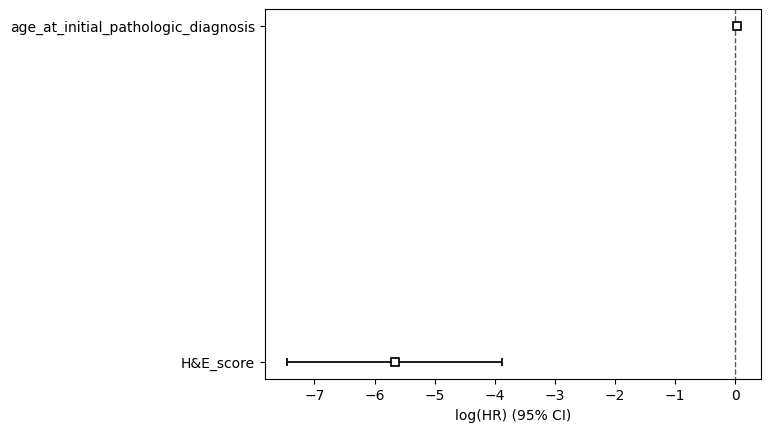

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -544.50
         time fit was run = 2023-11-30 06:36:07 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
H&E_score                            -4.76       0.01       1.04            -6.80            -2.72                 0.00                 0.07
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.06                 1.01                 1.06

                                      cmp to     z      p   -log2(p)
covariate                                                           
H&E_score                               0.00 -4.57 <0.005      17.67
age_at_initial_pathologic_diagnosis     0.00  2.43   0.02       6.04
---
Concordance = 0.61
Partial AIC = 1093.01
log-likelihood ratio test = 21.43 on 2 df
-log2(p) of ll-ratio test = 15.46

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
H&E_score                           -4.761955   0.008549  1.041324   
age_at_initial_pathologic_diagnosis  0.033497   1.034064  0.013802   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
H&E_score                                 -6.802912       -2.720998   
age_at_initial_pathologic_diagnosis        0.006444        0.060549   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
H&E_score                                       0.001111             0.065809   
age_at_initial_pathologic_diagnosis             1.006465             1.062419   

                                     cmp to         z         p   -log2(p)  
covariate                       

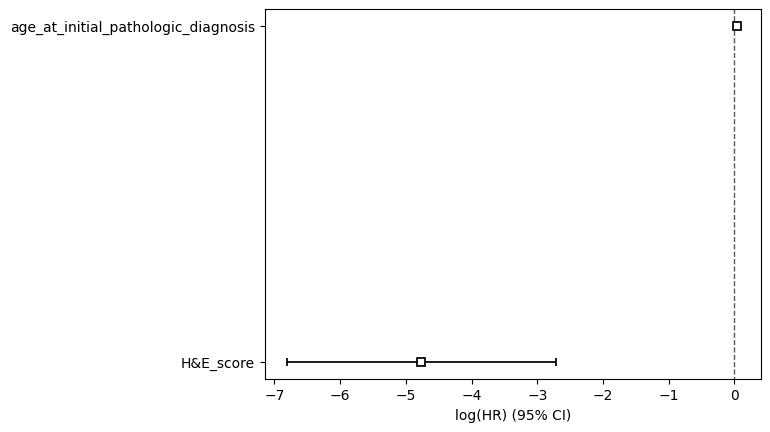

/media/oscar/b92cef6f-0be0-40dd-9cbd-0950333b5a47/TCGA-OV Tissue Slide/github/Codes/evaluation_func.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_pfs['Cox_score'] = cox_pfs.predict_partial_hazard(df_with_score_and_pfs[['H&E_score','age_at_initial_pathologic_diagnosis']])
/media/oscar/b92cef6f-0be0-40dd-9cbd-0950333b5a47/TCGA-OV Tissue Slide/github/Codes/evaluation_func.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_os['Cox_score'] = cox_os.predict_partial_h

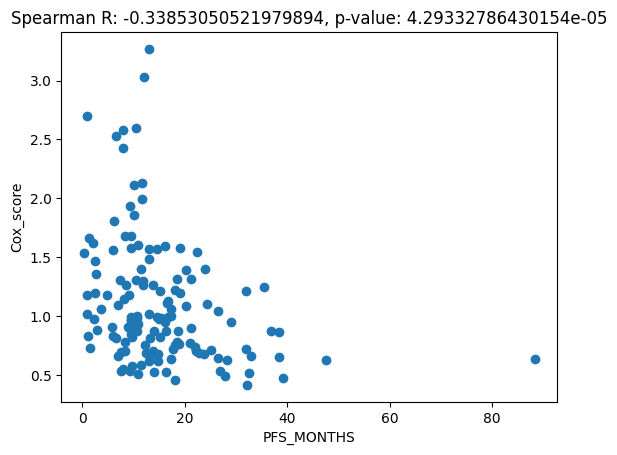

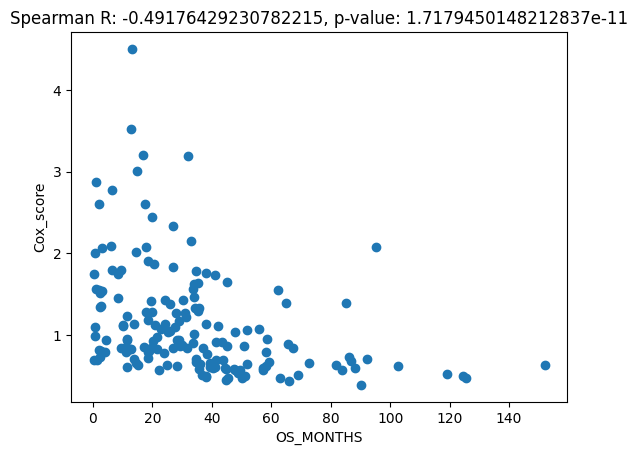

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

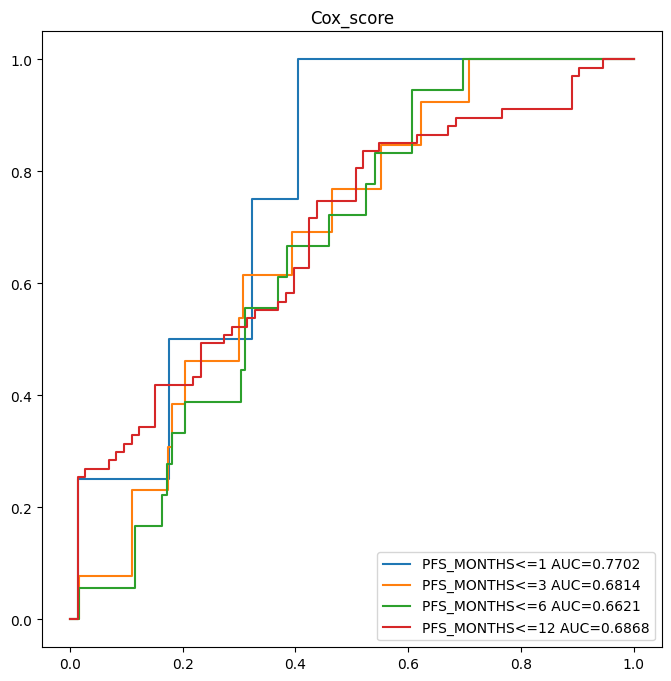

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

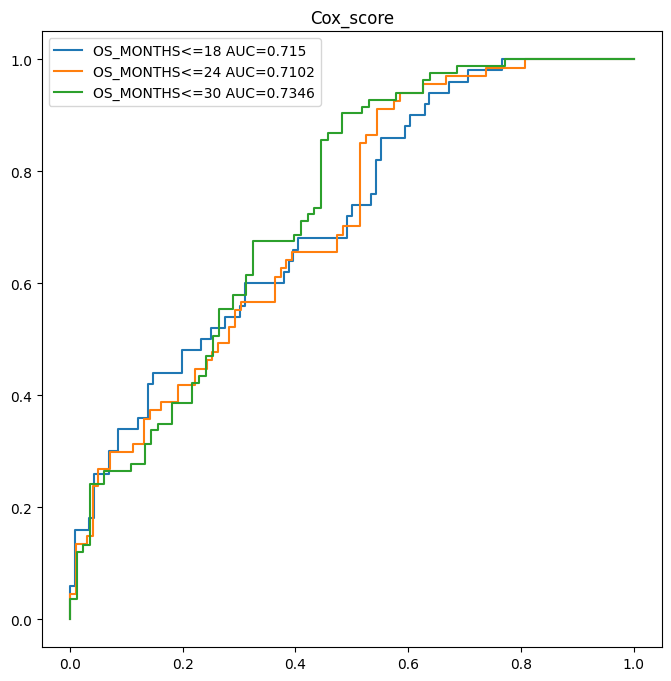

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

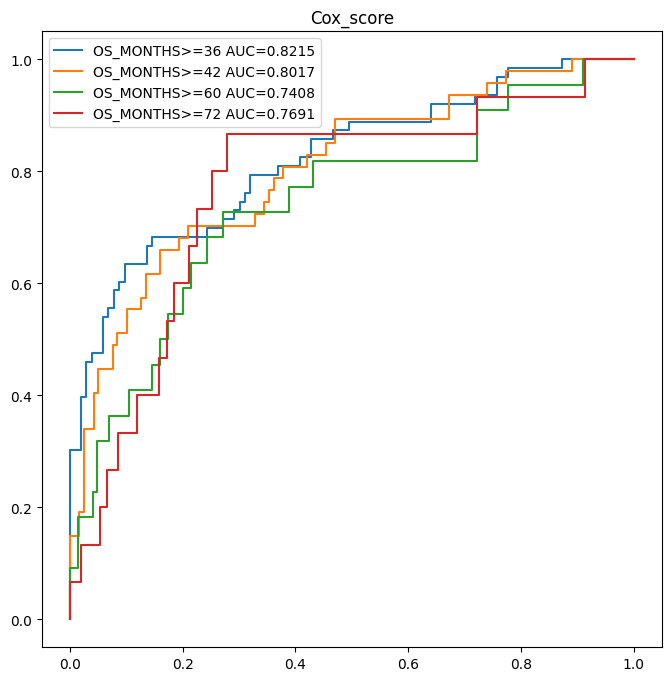

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -544.50
         time fit was run = 2023-11-30 06:36:08 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
H&E_score                            -4.76       0.01       1.04            -6.80            -2.72                 0.00                 0.07

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  2.43   0.02       6.04
H&E_score                               0.00 -4.57 <0.005      17.67
---
Concordance = 0.61
Partial AIC = 1093.01
log-likelihood ratio test = 21.43 on 2 df
-log2(p) of ll-ratio test = 15.46

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.033497   1.034064  0.013802   
H&E_score                           -4.761955   0.008549  1.041324   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.006444        0.060549   
H&E_score                                 -6.802912       -2.720998   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.006465             1.062419   
H&E_score                                       0.001111             0.065809   

                                     cmp to         z         p   -log2(p)  
covariate                       

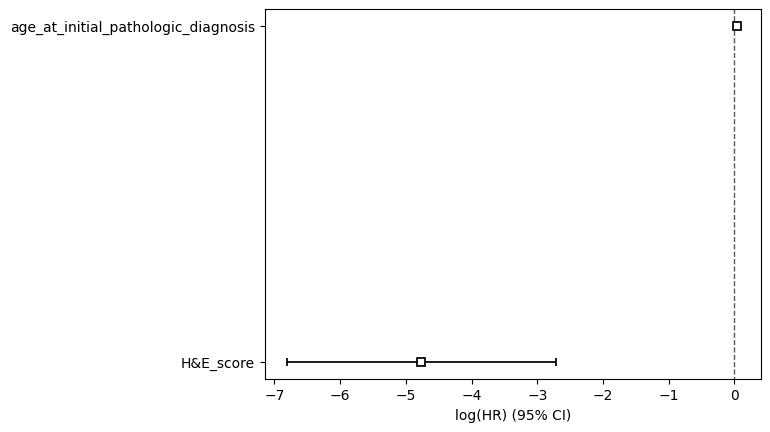

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -667.04
         time fit was run = 2023-11-30 06:36:08 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.01             0.00             0.05                 1.00                 1.05
H&E_score                            -5.66       0.00       0.91            -7.45            -3.87                 0.00                 0.02

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  2.21   0.03       5.21
H&E_score                               0.00 -6.21 <0.005      30.78
---
Concordance = 0.67
Partial AIC = 1338.08
log-likelihood ratio test = 38.05 on 2 df
-log2(p) of ll-ratio test = 27.45

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.027010   1.027378  0.012222   
H&E_score                           -5.662601   0.003473  0.912361   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.003056        0.050964   
H&E_score                                 -7.450795       -3.874408   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.003061             1.052285   
H&E_score                                       0.000581             0.020767   

                                     cmp to         z             p   -log2(p)  
covariate                   

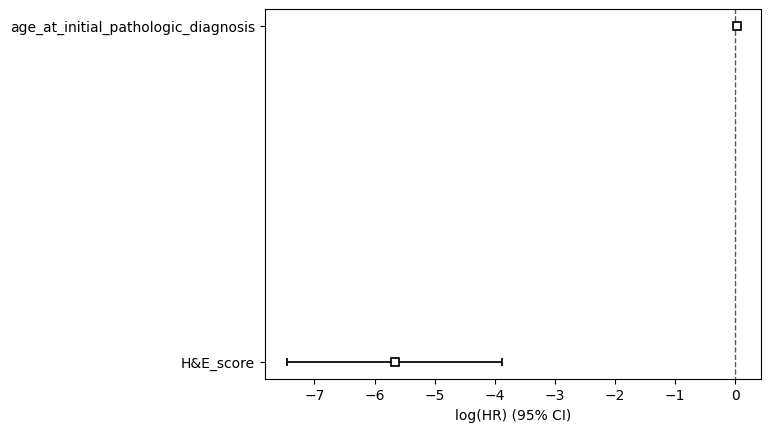

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -669.45
         time fit was run = 2023-11-30 06:36:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -5.44       0.00       0.90            -7.21            -3.67                 0.00                 0.03

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -6.02 <0.005      29.09
---
Concordance = 0.65
Partial AIC = 1340.89
log-likelihood ratio test = 33.24 on 1 df
-log2(p) of ll-ratio test = 26.87

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -5.436808   0.004353  0.903272       -7.207188       -3.666428   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.000741             0.025568     0.0 -6.019017   

                      p  -log2(p)  
covariate                          
H&E_score  1.754796e-09  29.08605  


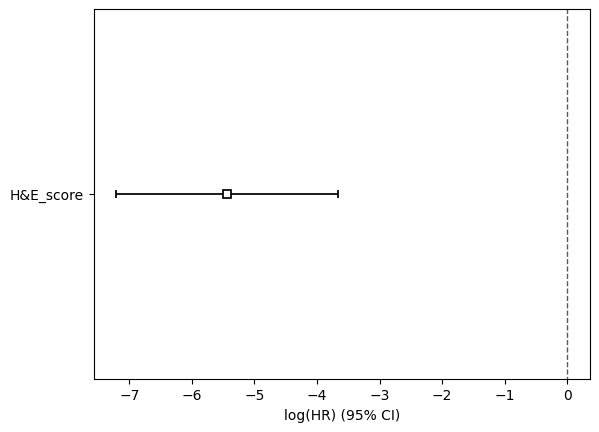

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -547.36
         time fit was run = 2023-11-30 06:36:08 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -4.10       0.02       0.98            -6.03            -2.17                 0.00                 0.11

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -4.17 <0.005      15.02
---
Concordance = 0.61
Partial AIC = 1096.73
log-likelihood ratio test = 15.71 on 1 df
-log2(p) of ll-ratio test = 13.73

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -4.099773   0.016576  0.982455        -6.02535       -2.174196   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.002417               0.1137     0.0 -4.172986   

                 p   -log2(p)  
covariate                      
H&E_score  0.00003  15.021637  


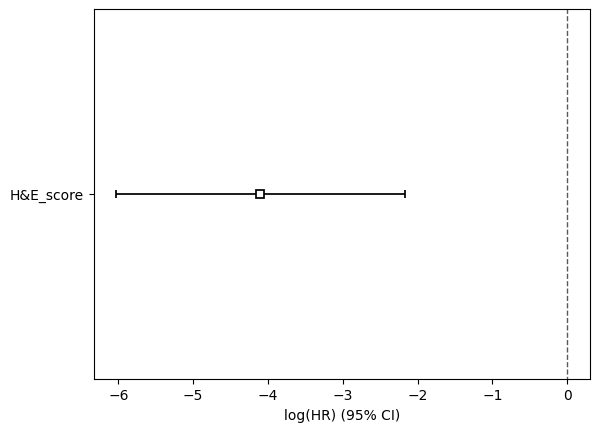

<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 166
number of events observed = 166
   partial log-likelihood = -684.76
         time fit was run = 2023-11-30 06:36:08 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.00             0.04                 1.00                 1.05

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 1.62 0.10       3.26
---
Concordance = 0.54
Partial AIC = 1371.52
log-likelihood ratio test = 2.61 on 1 df
-log2(p) of ll-ratio test = 3.23

                                     coef  exp(coef)  se(coef)  \
covariate                                                        
age_at_initial_pathologic_diagnosis  0.02   1.020201  0.012312   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.004131        0.044131   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.995878             1.045119   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  1.624465  0.104277  3.261512  


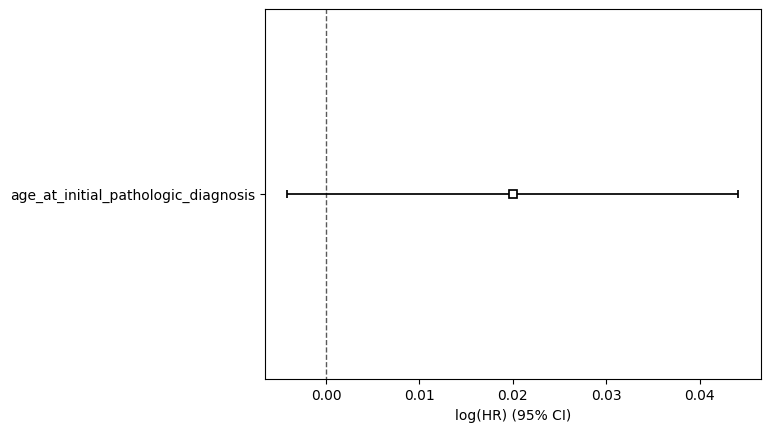

<lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 140
number of events observed = 140
   partial log-likelihood = -554.12
         time fit was run = 2023-11-30 06:36:08 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01            -0.01             0.05                 0.99                 1.05

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 1.50 0.13       2.90
---
Concordance = 0.53
Partial AIC = 1110.23
log-likelihood ratio test = 2.21 on 1 df
-log2(p) of ll-ratio test = 2.87

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.020311   1.020519  0.013541   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.006229        0.046852   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis              0.99379             1.047966   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  1.499961  0.133624  2.903744  


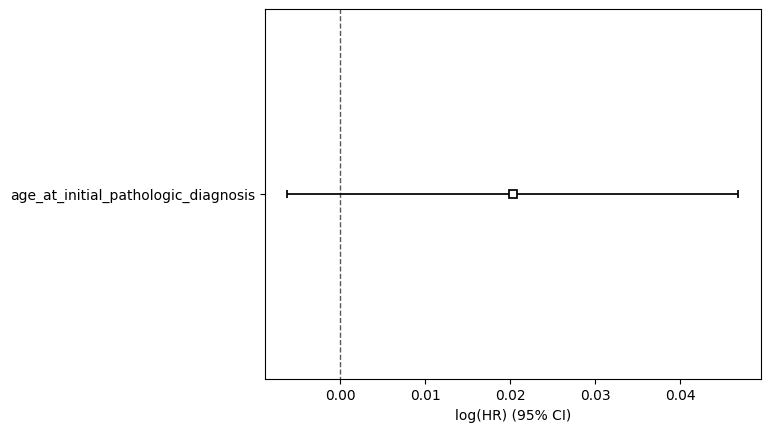

In [22]:
train_cox_os, train_cox_pfs = evaluation_func.model_performance(result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60], result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60])

59.5


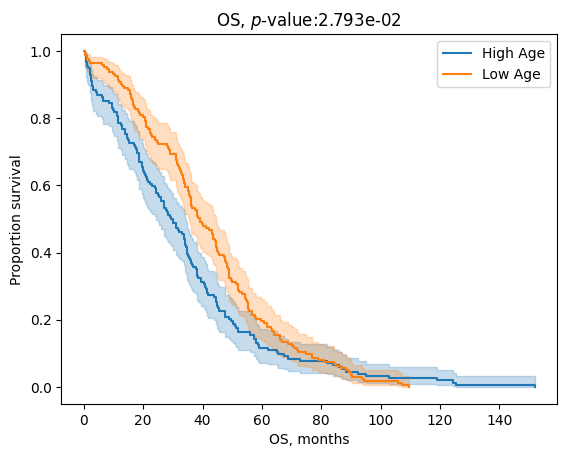

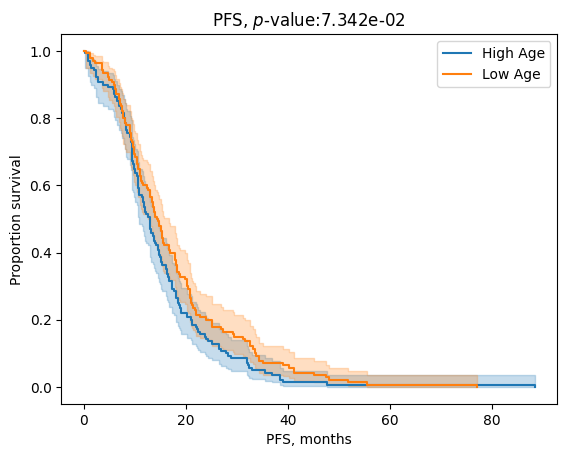

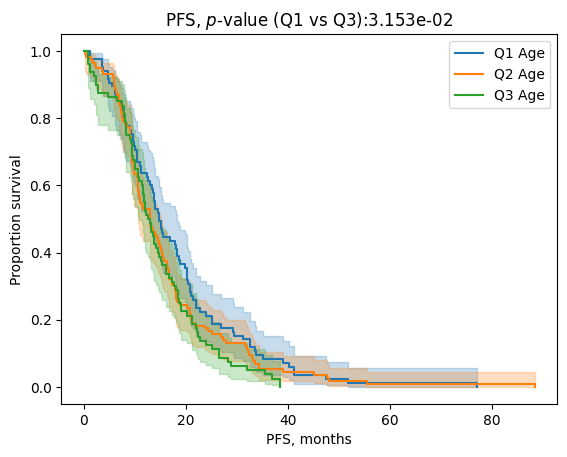

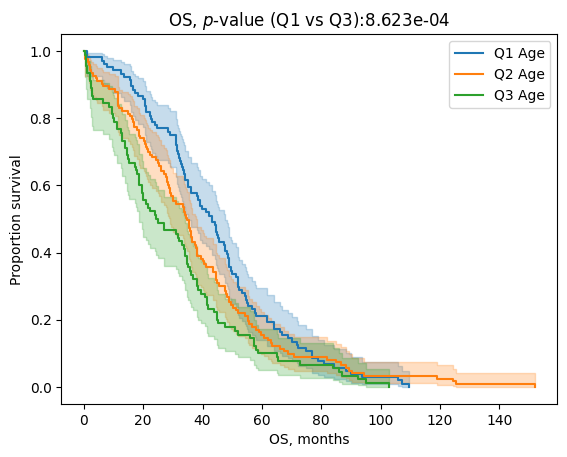

In [23]:
evaluation_func.kmplots(result_train_score_os_clinical,result_train_score_pfs_clinical,'age_at_initial_pathologic_diagnosis')

69.0


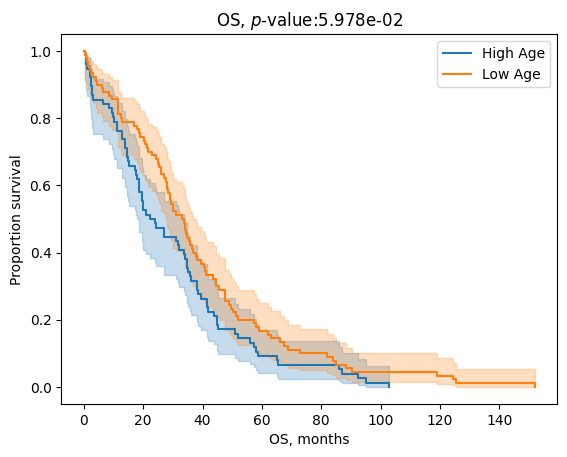

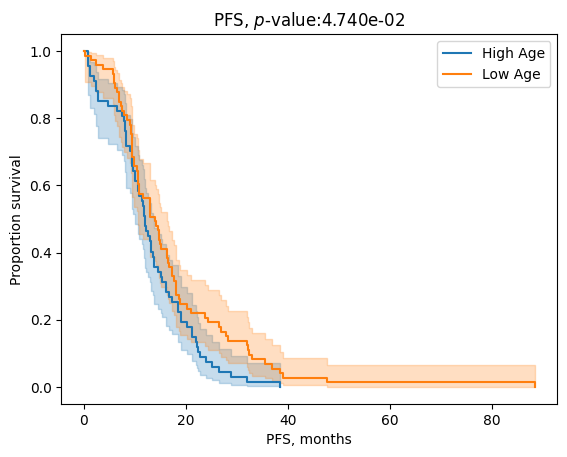

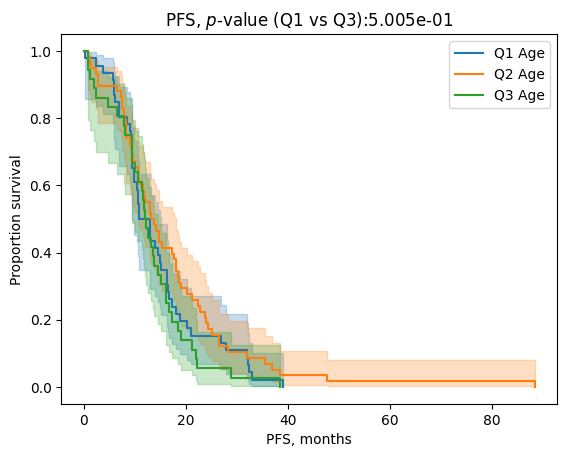

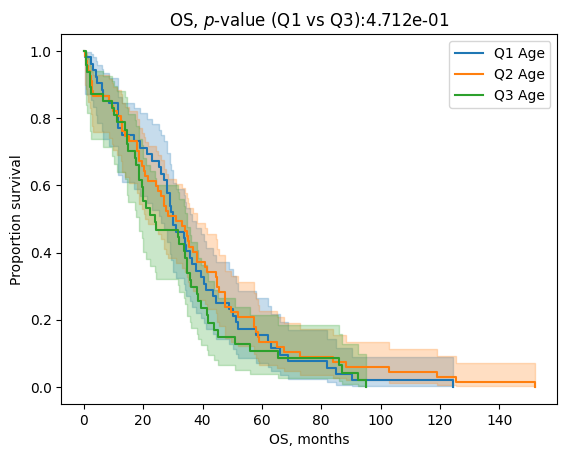

In [24]:
evaluation_func.kmplots(result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'age_at_initial_pathologic_diagnosis')

0.6005383039514224


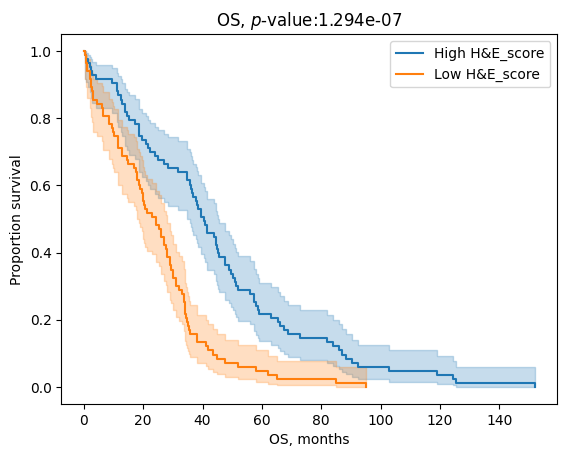

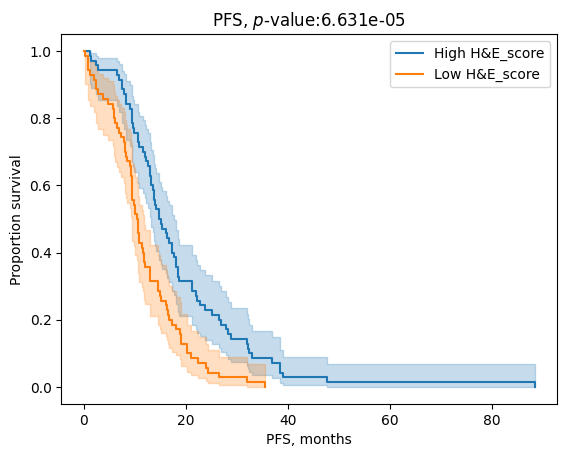

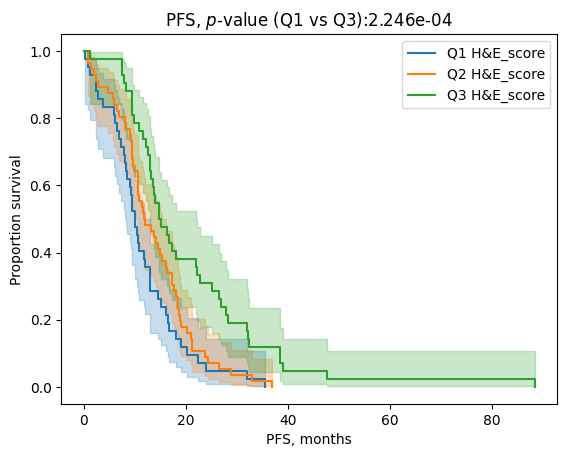

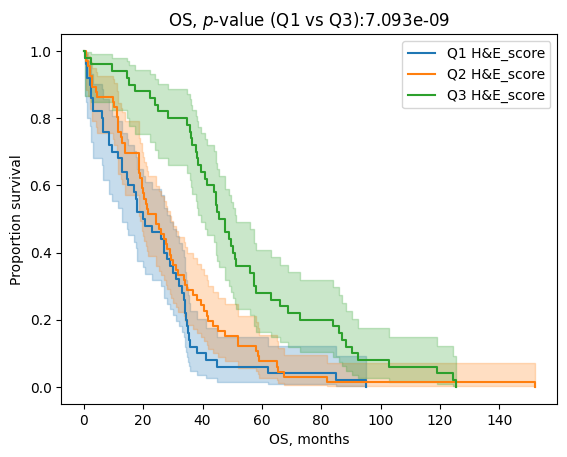

In [25]:
evaluation_func.kmplots(result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'H&E_score')

1.1351024431143986


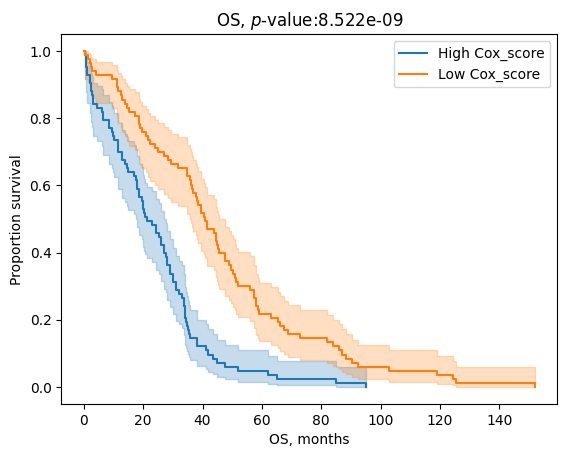

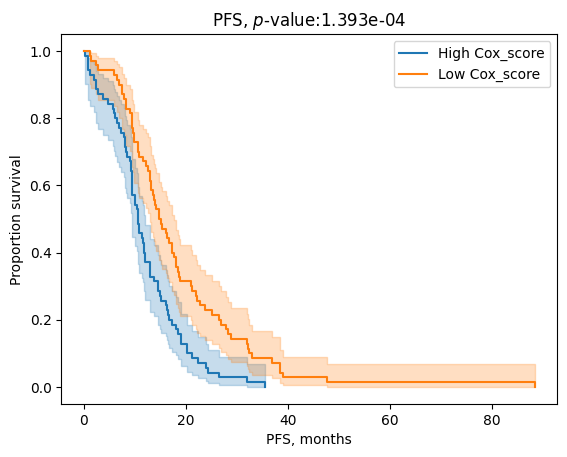

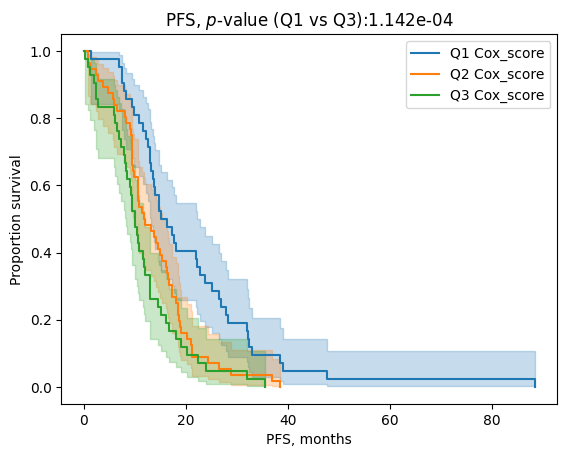

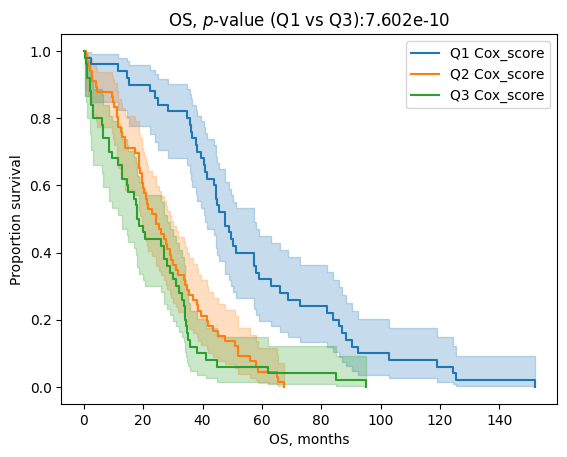

In [26]:
evaluation_func.kmplots(result_train_score_os_clinical[result_train_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_train_score_pfs_clinical[result_train_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'Cox_score')

In [17]:
tcga_test_df = evaluation_func.evaluate_5CV(test_dataloader, y_test.index, [0,1,2,3,4],folder)
tcga_test_df

Fold 0 model: epoch_09loss0.039871_AUROC_0.704545.pt
Fold 0 AUROC: 0.6527423469387755
Fold 1 model: epoch_09loss0.041579_AUROC_0.687184.pt
Fold 1 AUROC: 0.5932185374149659
Fold 2 model: epoch_03loss0.043594_AUROC_0.628121.pt
Fold 2 AUROC: 0.6364795918367347
Fold 3 model: epoch_09loss0.039309_AUROC_0.702508.pt
Fold 3 AUROC: 0.6612457482993197
Fold 4 model: epoch_09loss0.041122_AUROC_0.758620.pt
Fold 4 AUROC: 0.6647534013605442


/media/oscar/b92cef6f-0be0-40dd-9cbd-0950333b5a47/TCGA-OV Tissue Slide/github/Codes/evaluation_func.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp["H&E_score"] += cv_predicted_df_dict[fold]["H&E_score"]


H&E_score  gold  layers
849    0.513836   0.0     0.0
1061   0.664161   0.0     0.0
341    0.655241   0.0     0.0
6      0.570117   0.0     0.0
535    0.686475   1.0     0.0
...         ...   ...     ...
44     0.613381   0.0     0.0
54     0.537423   1.0     0.0
287    0.700850   1.0     0.0
355    0.546572   1.0     0.0
213    0.499194   0.0     0.0

[194 rows x 3 columns]

In [27]:
manifest_pfs['PFS_STATUS'] = manifest_pfs['PFS_STATUS'].astype(int)
result_score_pfs = manifest_pfs.join(tcga_test_df, how='inner')[['case.id','PFS_STATUS','PFS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_score_pfs = result_score_pfs[result_score_pfs['PFS_STATUS']==1]
result_score_pfs
result_score_pfs_clinical = result_score_pfs.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')
result_score_pfs_clinical['age_at_initial_pathologic_diagnosis'] = result_score_pfs_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

manifest_os['OS_STATUS'] = manifest_os['OS_STATUS'].astype(int)
result_score_os = manifest_os.join(tcga_test_df, how='inner')[['case.id','OS_STATUS','OS_MONTHS','H&E_score','gold']].groupby('case.id').mean()
result_score_os = result_score_os[result_score_os['OS_STATUS']==1]
result_score_os
result_score_os_clinical = result_score_os.join(clinical_gdc[['age_at_initial_pathologic_diagnosis','clinical_stage']], how='inner')
result_score_os_clinical['age_at_initial_pathologic_diagnosis'] = result_score_os_clinical['age_at_initial_pathologic_diagnosis'].astype(int)

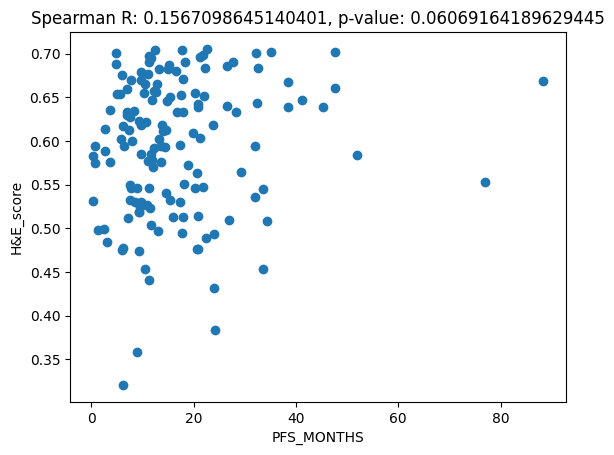

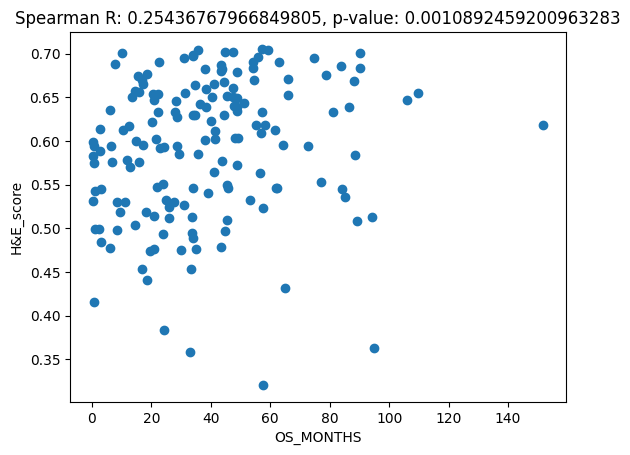

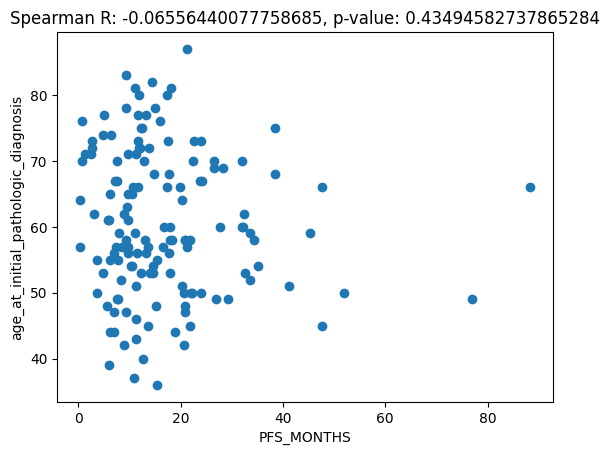

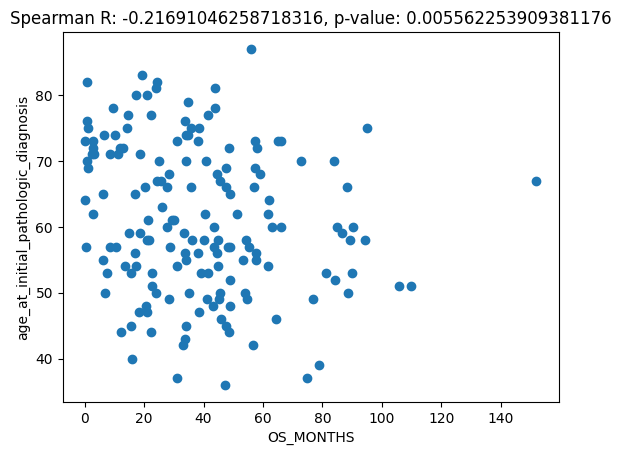

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

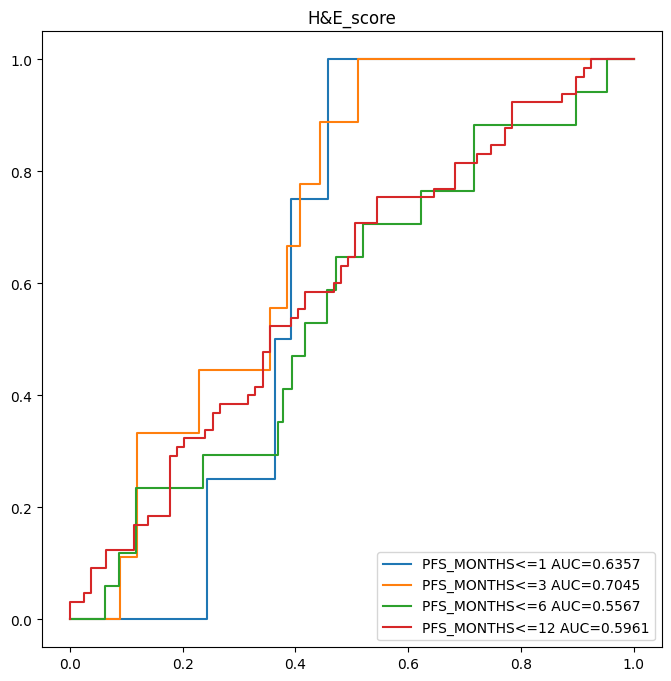

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

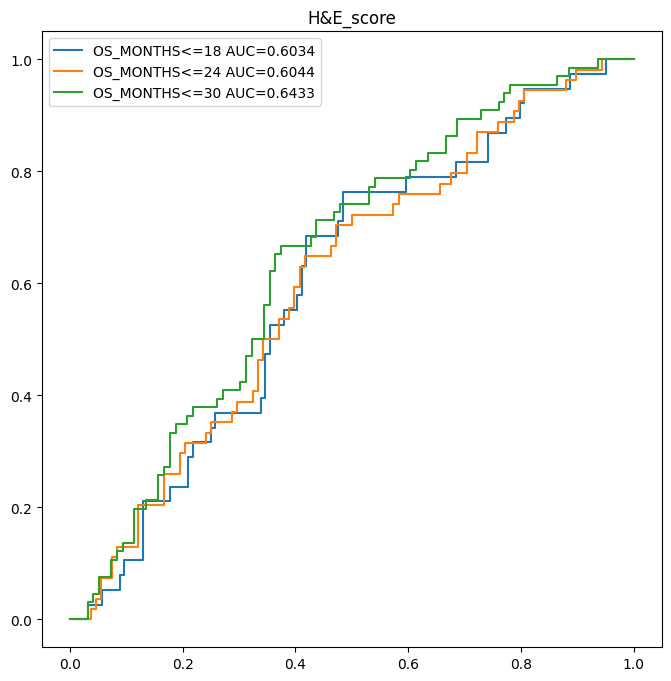

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

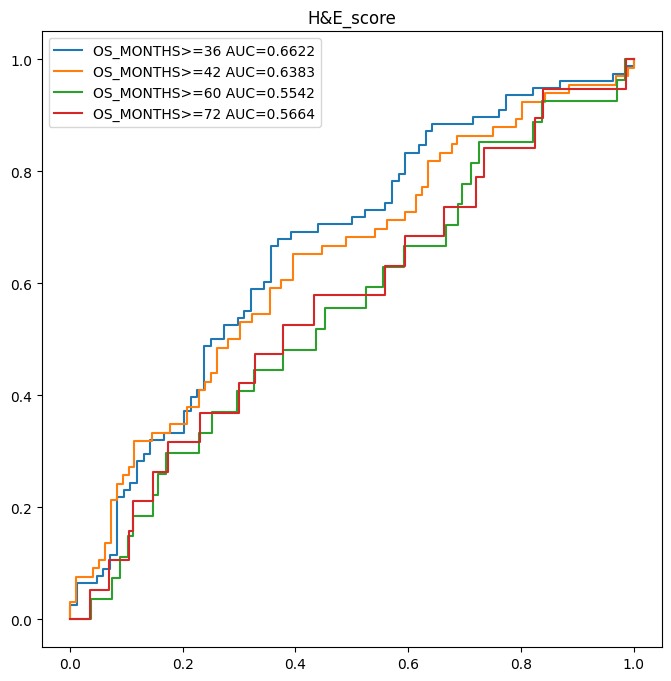

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

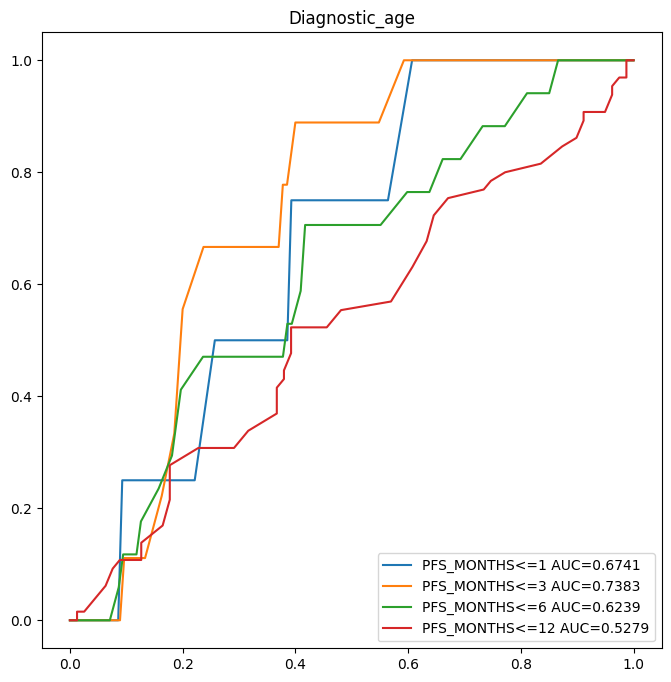

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

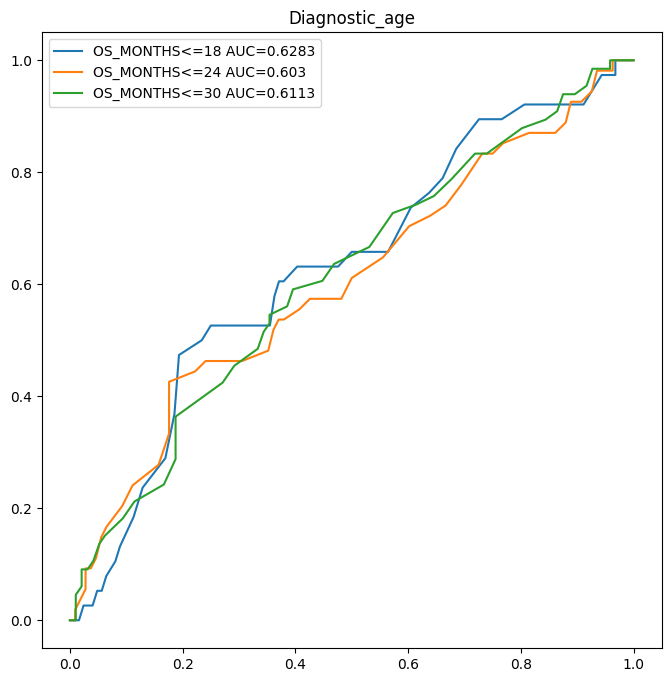

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

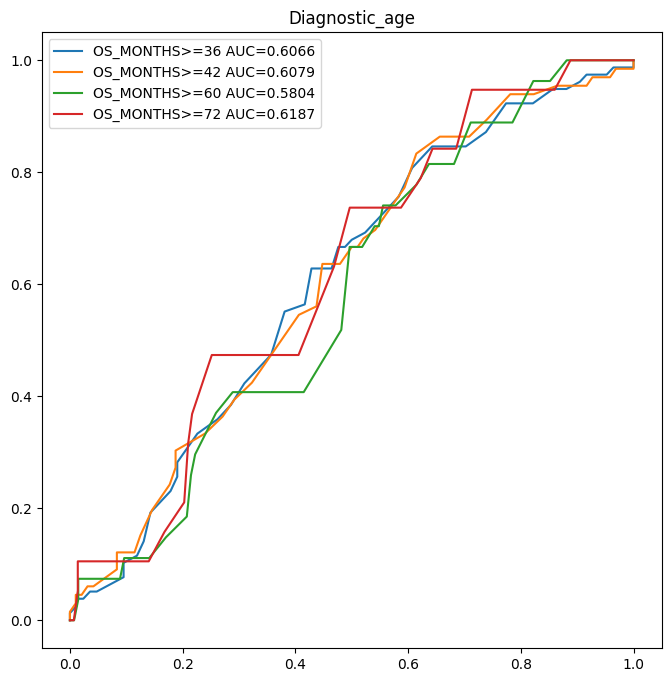

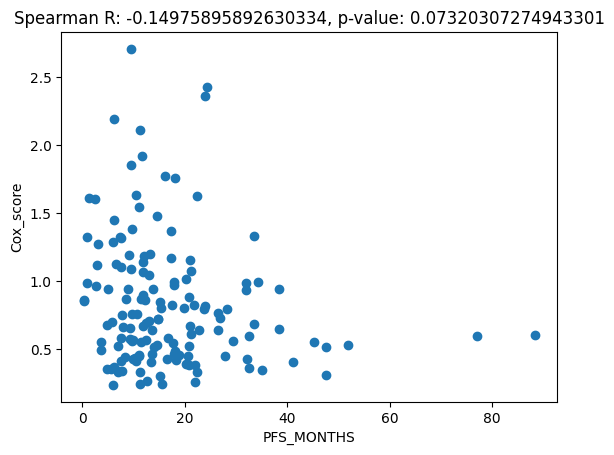

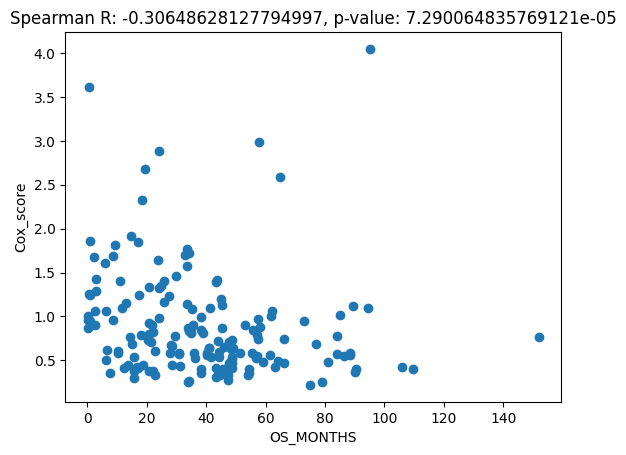

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

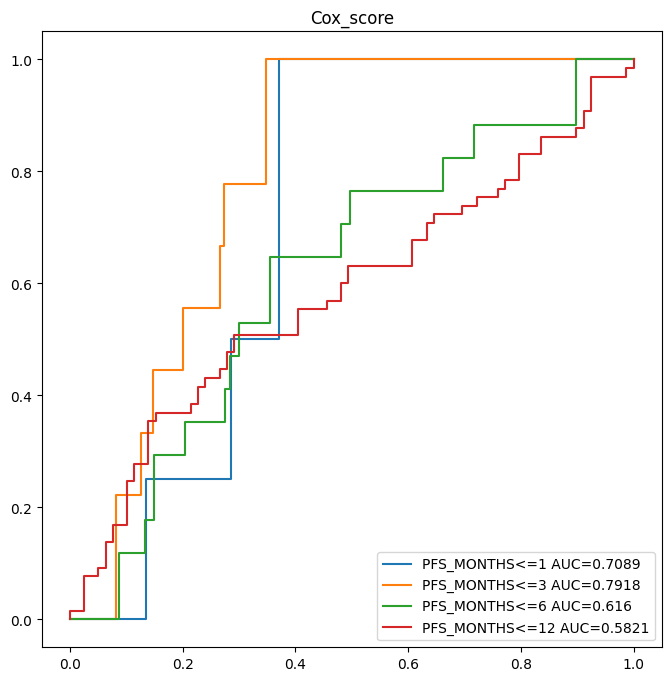

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

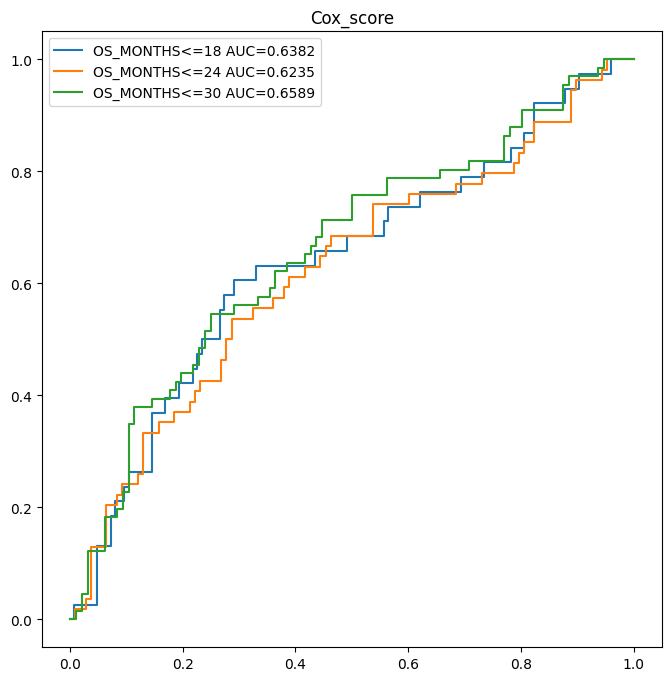

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

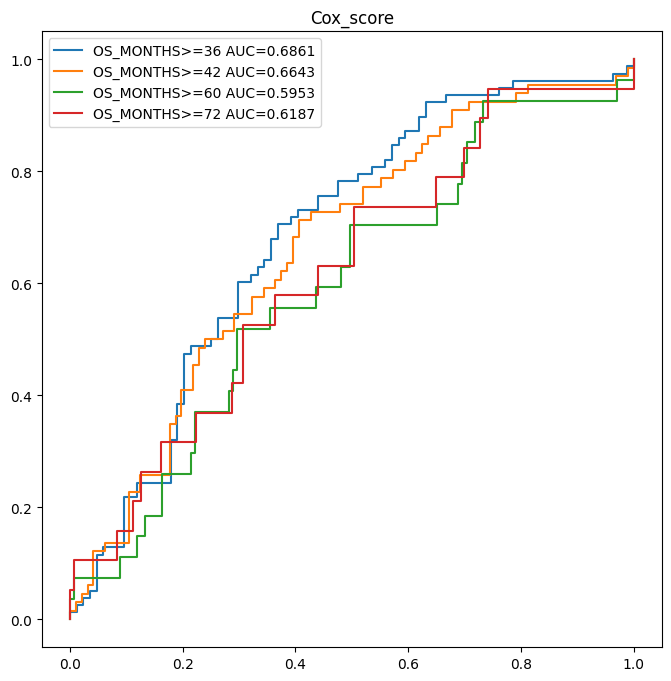

<lifelines.CoxPHFitter: fitted with 144 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 144
   partial log-likelihood = -573.14
         time fit was run = 2023-11-30 06:36:15 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02
H&E_score                            -1.83       0.16       1.04            -3.86             0.20                 0.02                 1.22

                                      cmp to     z    p   -log2(p)
covariate                                                         
age_at_initial_pathologic_diagnosis     0.00  1.01 0.31       1.69
H&E_score                               0.00 -1.76 0.08       3.69
---
Concordance = 0.55
Partial AIC = 1150.27
log-likelihood ratio test = 3.84 on 2 df
-log2(p) of ll-ratio test = 2.77

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.008218   1.008252  0.008107   
H&E_score                           -1.828029   0.160730  1.035747   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.007672        0.024108   
H&E_score                                 -3.858056        0.201998   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.992357             1.024401   
H&E_score                                       0.021109             1.223845   

                                     cmp to         z         p  -log2(p)  
covariate                        

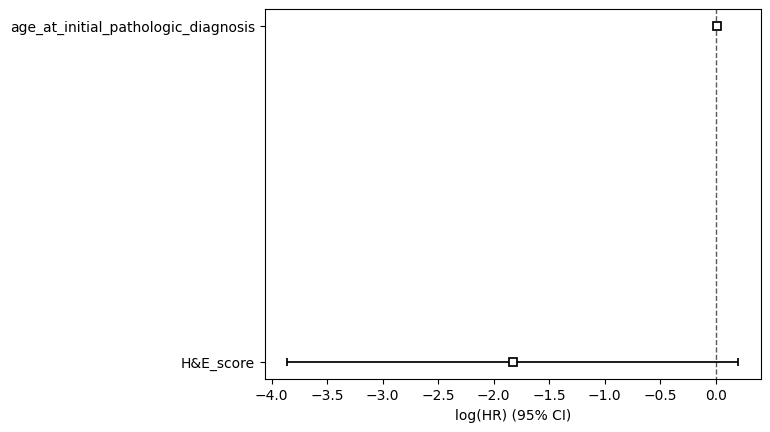

<lifelines.CoxPHFitter: fitted with 162 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 162
   partial log-likelihood = -662.47
         time fit was run = 2023-11-30 06:36:15 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01             0.00             0.03                 1.00                 1.03
H&E_score                            -1.26       0.28       0.88            -2.98             0.46                 0.05                 1.59

                                      cmp to     z    p   -log2(p)
covariate                                                         
age_at_initial_pathologic_diagnosis     0.00  1.96 0.05       4.34
H&E_score                               0.00 -1.43 0.15       2.72
---
Concordance = 0.60
Partial AIC = 1328.94
log-likelihood ratio test = 6.37 on 2 df
-log2(p) of ll-ratio test = 4.59

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.014730   1.014839  0.007500   
H&E_score                           -1.257709   0.284305  0.877181   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.000030        0.029430   
H&E_score                                 -2.976952        0.461535   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.000030             1.029867   
H&E_score                                       0.050948             1.586507   

                                     cmp to         z         p  -log2(p)  
covariate                        

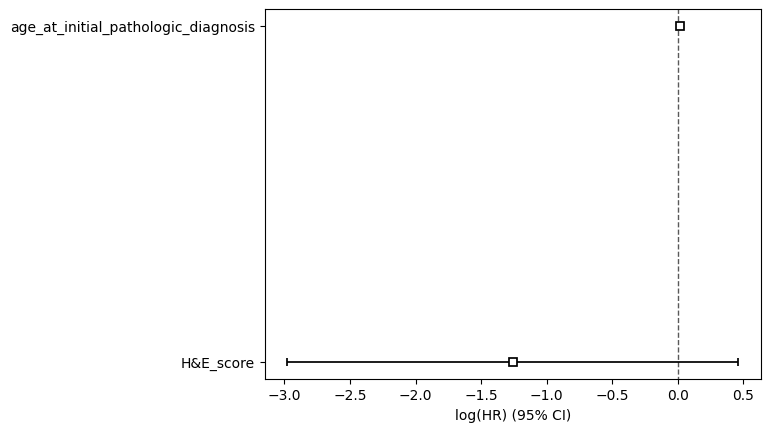

<lifelines.CoxPHFitter: fitted with 162 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 162
   partial log-likelihood = -664.39
         time fit was run = 2023-11-30 06:36:15 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -1.43       0.24       0.88            -3.17             0.30                 0.04                 1.34

            cmp to     z    p   -log2(p)
covariate                               
H&E_score     0.00 -1.62 0.10       3.26
---
Concordance = 0.58
Partial AIC = 1330.78
log-likelihood ratio test = 2.53 on 1 df
-log2(p) of ll-ratio test = 3.16

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -1.434479    0.23824  0.882974       -3.165076        0.296119   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.042211              1.34463     0.0 -1.624599   

                  p  -log2(p)  
covariate                      
H&E_score  0.104248  3.261907  


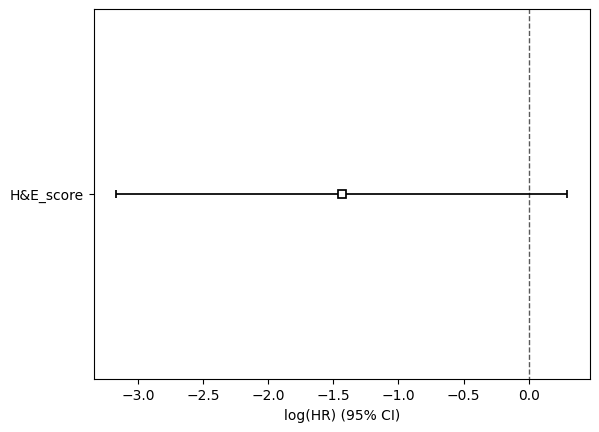

<lifelines.CoxPHFitter: fitted with 144 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 144
   partial log-likelihood = -573.65
         time fit was run = 2023-11-30 06:36:15 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -1.77       0.17       1.04            -3.81             0.27                 0.02                 1.31

            cmp to     z    p   -log2(p)
covariate                               
H&E_score     0.00 -1.70 0.09       3.49
---
Concordance = 0.55
Partial AIC = 1149.30
log-likelihood ratio test = 2.82 on 1 df
-log2(p) of ll-ratio test = 3.42

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -1.768821   0.170534  1.040065       -3.807311        0.269668   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.022208             1.309529     0.0 -1.700684   

                  p  -log2(p)  
covariate                      
H&E_score  0.089002  3.490014  


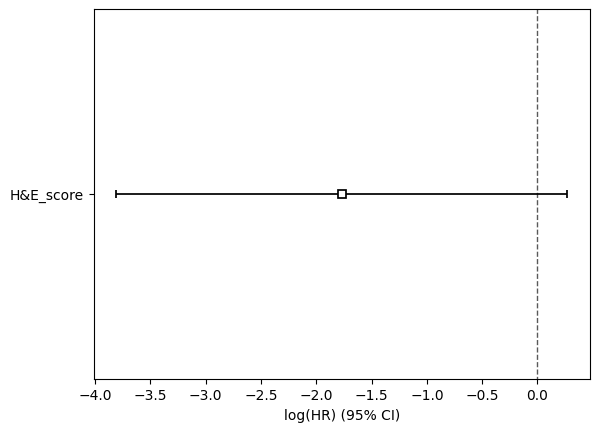

<lifelines.CoxPHFitter: fitted with 162 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 162
number of events observed = 162
   partial log-likelihood = -663.46
         time fit was run = 2023-11-30 06:36:15 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.02       1.02       0.01             0.00             0.03                 1.00                 1.03

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 2.10 0.04       4.79
---
Concordance = 0.57
Partial AIC = 1328.92
log-likelihood ratio test = 4.39 on 1 df
-log2(p) of ll-ratio test = 4.79

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.015597    1.01572  0.007439   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.001017        0.030178   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.001017             1.030638   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  2.096636  0.036026  4.794827  


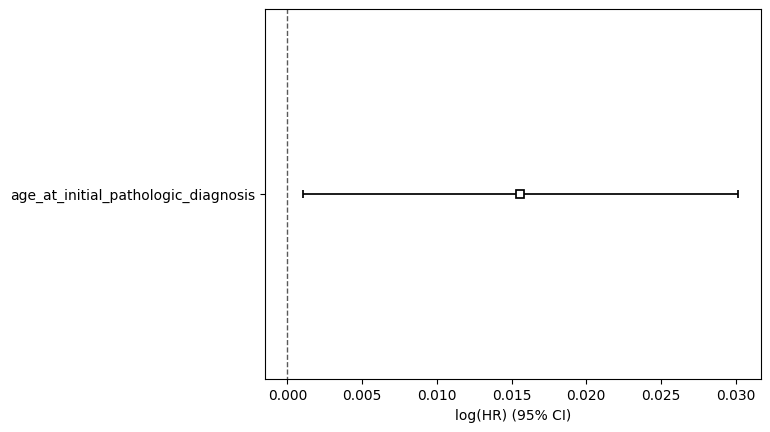

<lifelines.CoxPHFitter: fitted with 144 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 144
number of events observed = 144
   partial log-likelihood = -574.65
         time fit was run = 2023-11-30 06:36:15 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.01       1.01       0.01            -0.01             0.02                 0.99                 1.02

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 0.90 0.37       1.45
---
Concordance = 0.52
Partial AIC = 1151.30
log-likelihood ratio test = 0.81 on 1 df
-log2(p) of ll-ratio test = 1.45

                                        coef  exp(coef)  se(coef)  \
covariate                                                           
age_at_initial_pathologic_diagnosis  0.00727   1.007296  0.008044   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.008497        0.023036   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.991539             1.023304   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  0.903719  0.366144  1.449516  


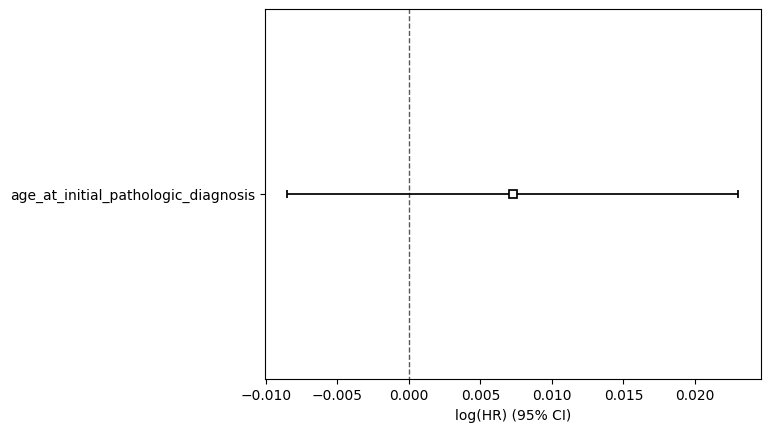

(<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>,
 <lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>)

In [28]:
evaluation_func.model_performance(result_score_pfs_clinical, result_score_os_clinical, train_cox_pfs, train_cox_os)

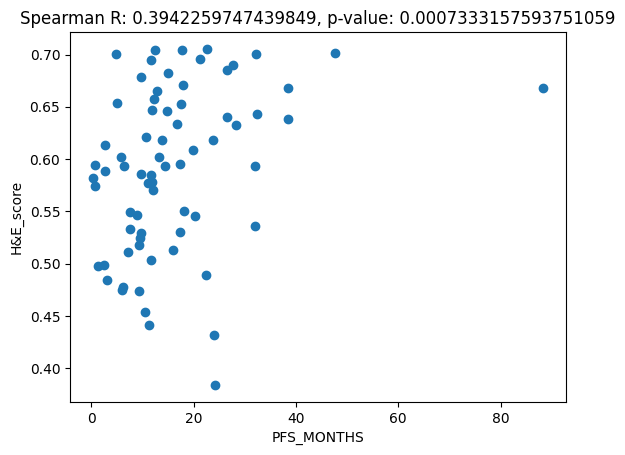

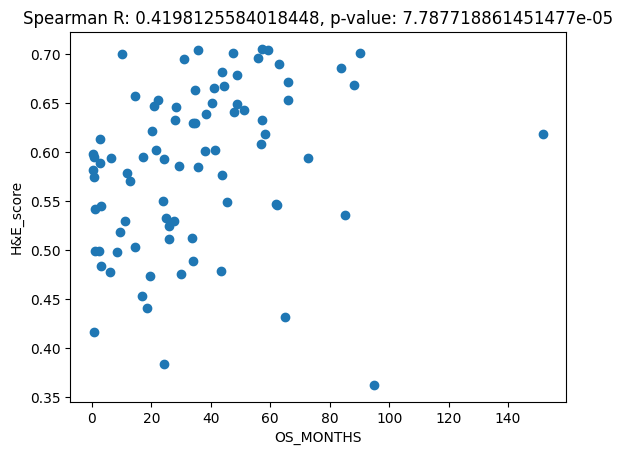

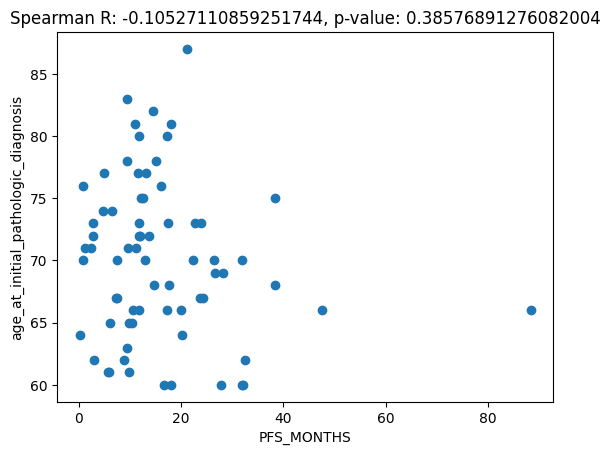

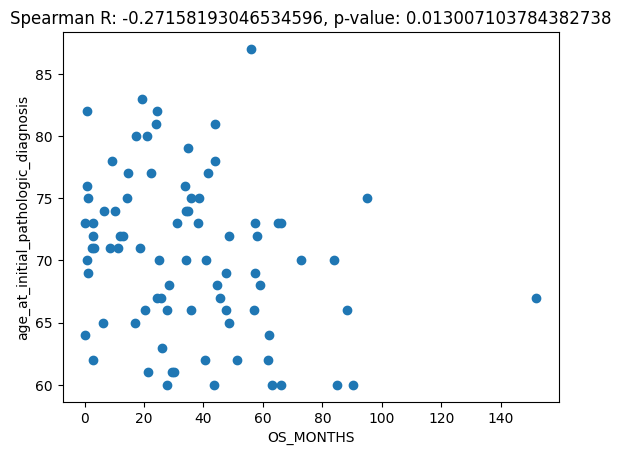

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

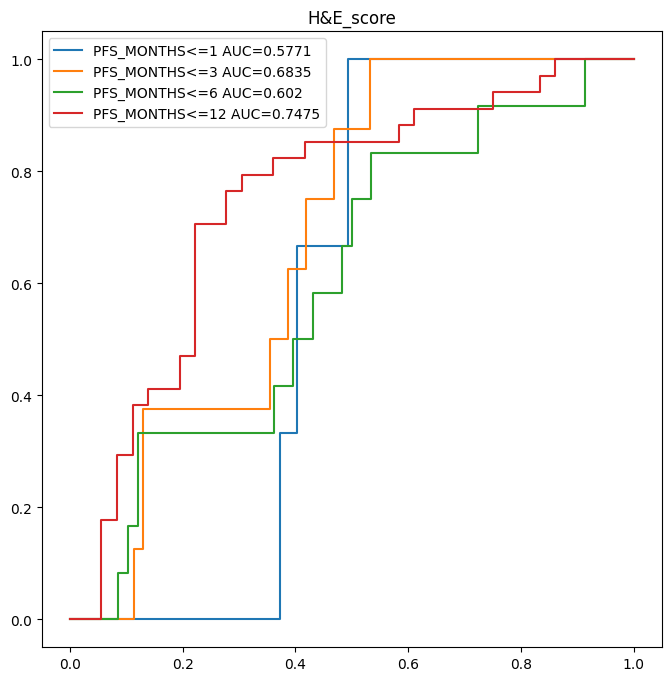

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

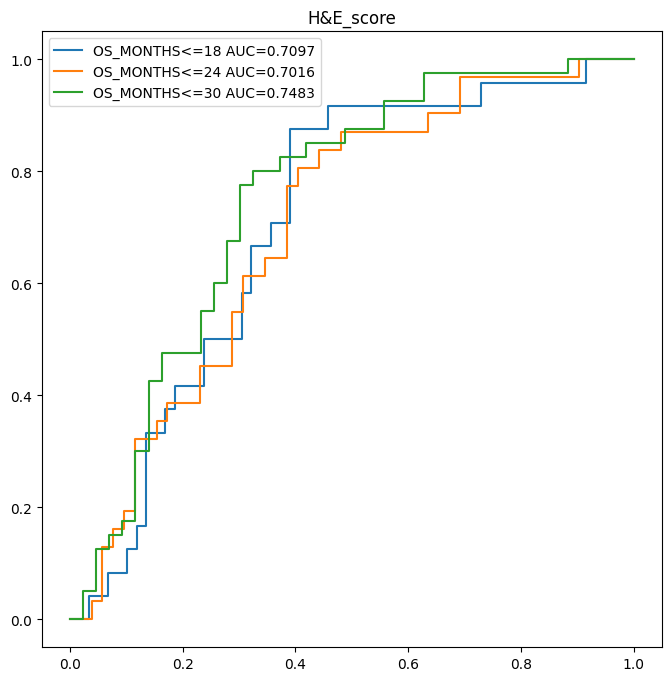

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

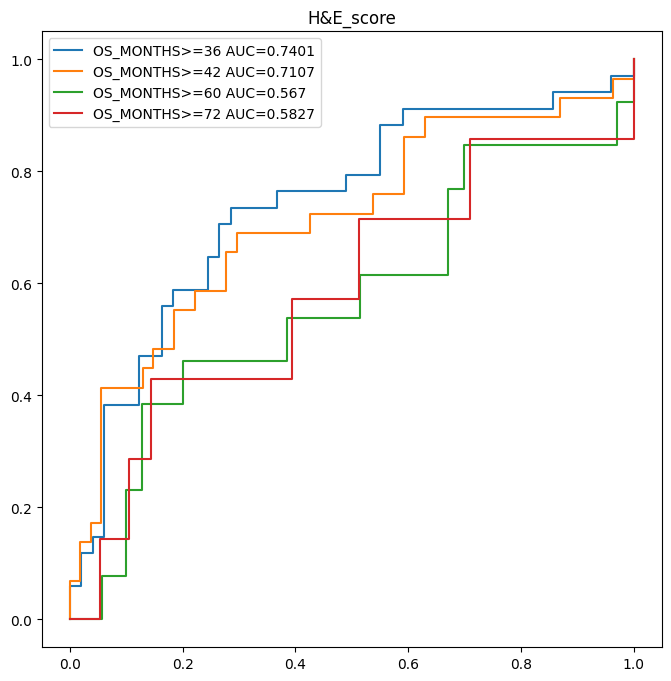

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

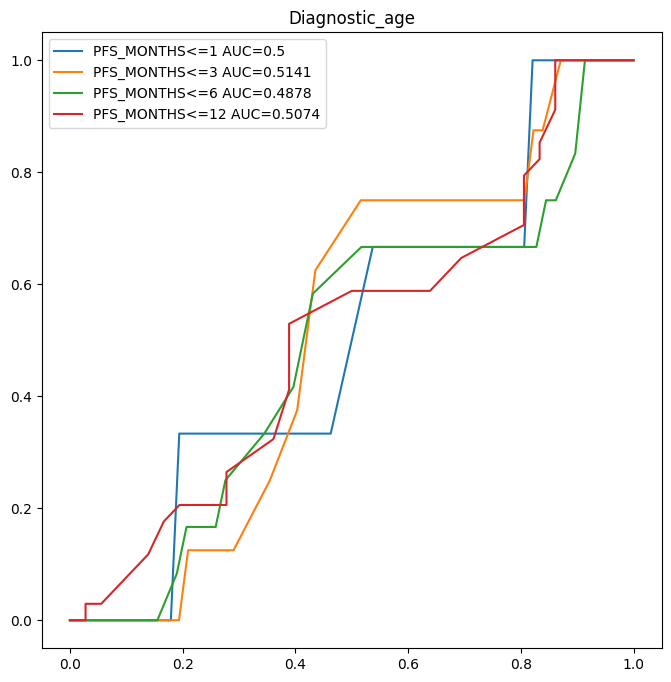

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

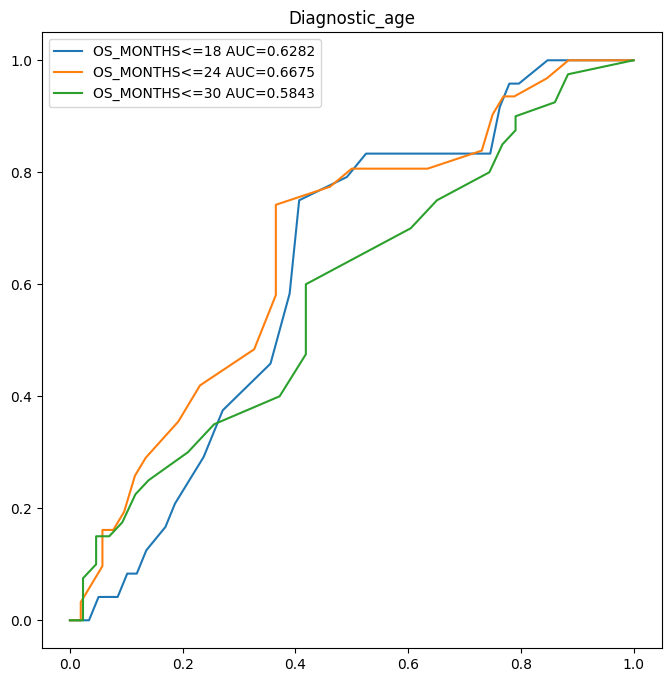

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

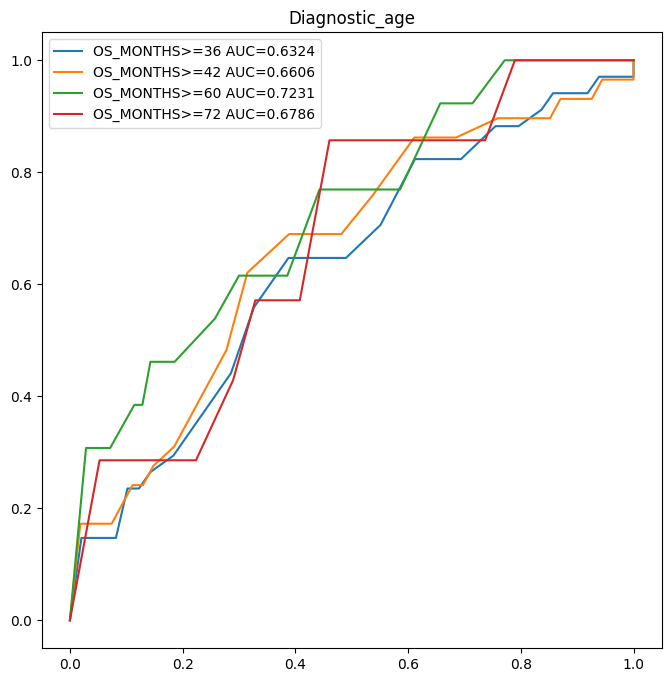

/media/oscar/b92cef6f-0be0-40dd-9cbd-0950333b5a47/TCGA-OV Tissue Slide/github/Codes/evaluation_func.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_pfs['Cox_score'] = cox_pfs.predict_partial_hazard(df_with_score_and_pfs[['H&E_score','age_at_initial_pathologic_diagnosis']])
/media/oscar/b92cef6f-0be0-40dd-9cbd-0950333b5a47/TCGA-OV Tissue Slide/github/Codes/evaluation_func.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_with_score_and_os['Cox_score'] = cox_os.predict_partial_h

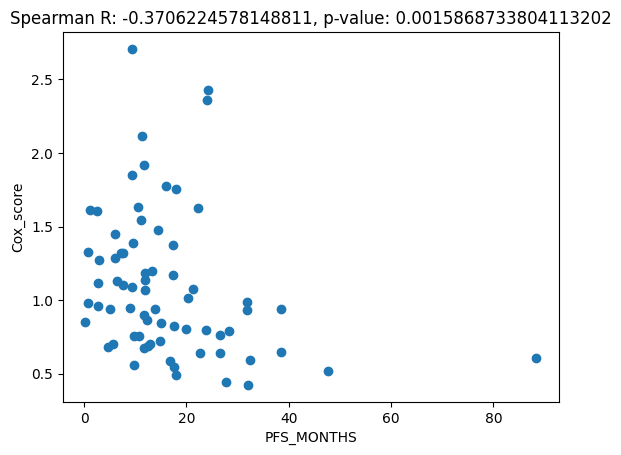

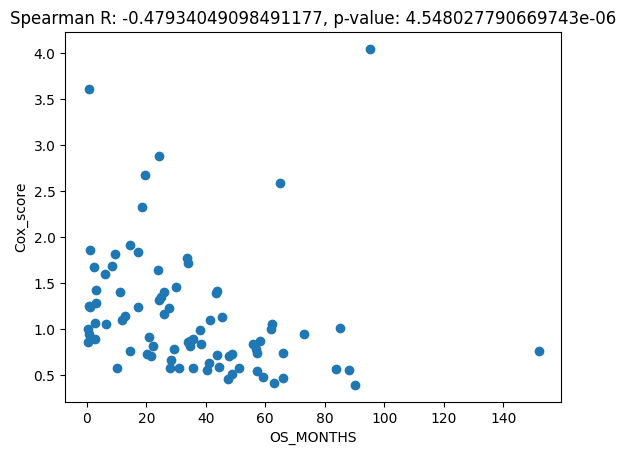

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

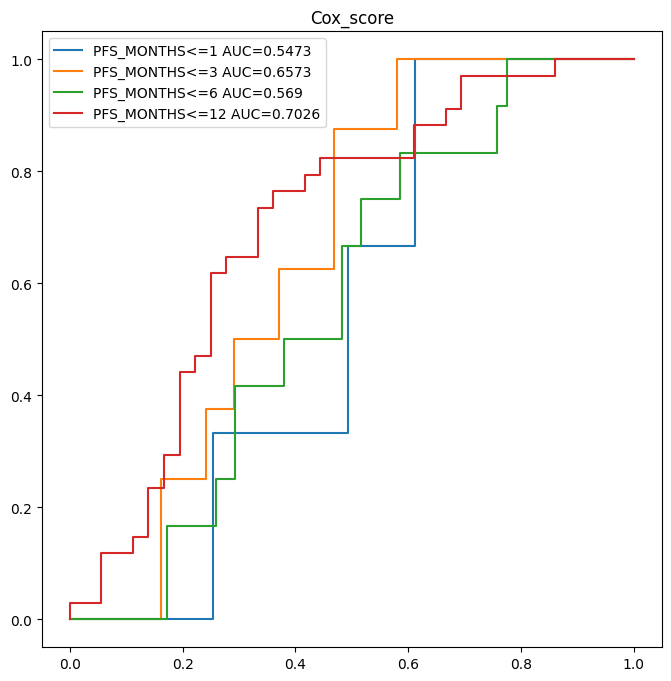

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

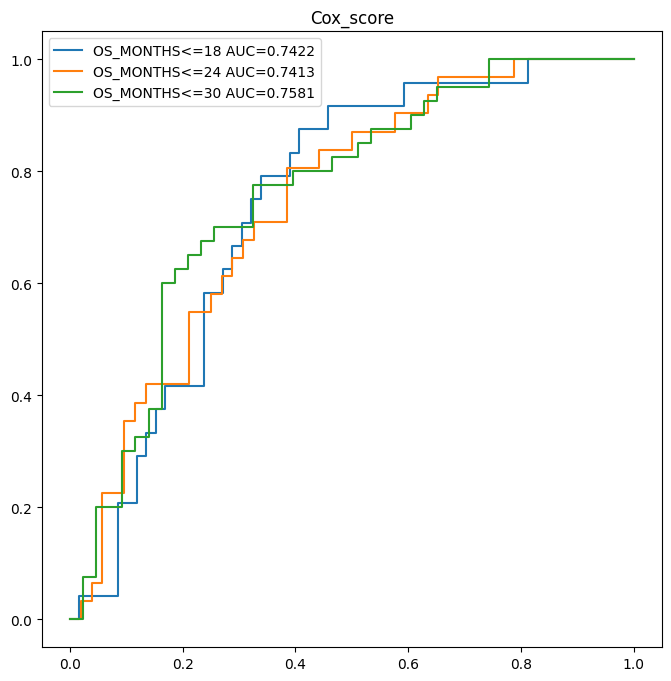

/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/oscar/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

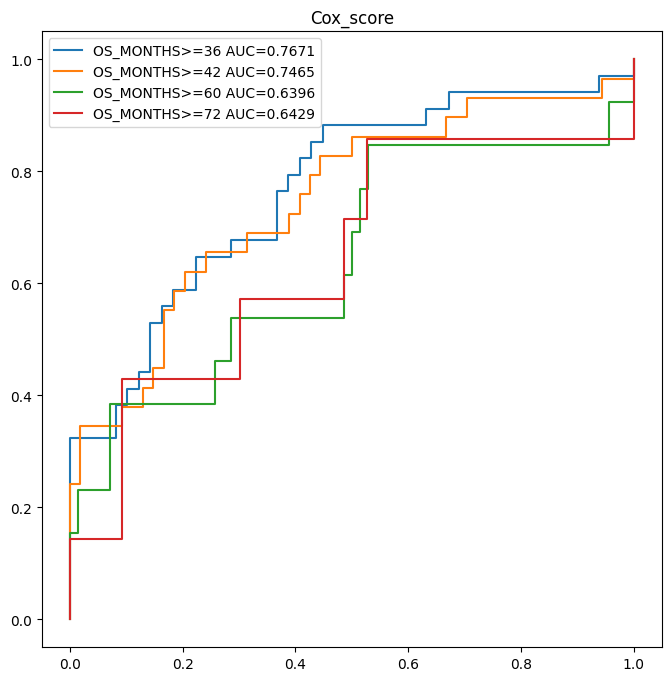

<lifelines.CoxPHFitter: fitted with 70 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 70
number of events observed = 70
   partial log-likelihood = -225.75
         time fit was run = 2023-11-30 06:36:16 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.02            -0.01             0.07                 0.99                 1.07
H&E_score                            -3.93       0.02       1.39            -6.65            -1.20                 0.00                 0.30

                                      cmp to     z      p   -log2(p)
covariate                                                           
age_at_initial_pathologic_diagnosis     0.00  1.38   0.17       2.57
H&E_score                               0.00 -2.82 <0.005       7.72
---
Concordance = 0.62
Partial AIC = 455.51
log-likelihood ratio test = 9.37 on 2 df
-log2(p) of ll-ratio test = 6.76

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.027025   1.027393  0.019640   
H&E_score                           -3.925663   0.019729  1.390123   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.011469        0.065519   
H&E_score                                 -6.650254       -1.201072   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.988596             1.067713   
H&E_score                                       0.001294             0.300871   

                                     cmp to         z         p  -log2(p)  
covariate                        

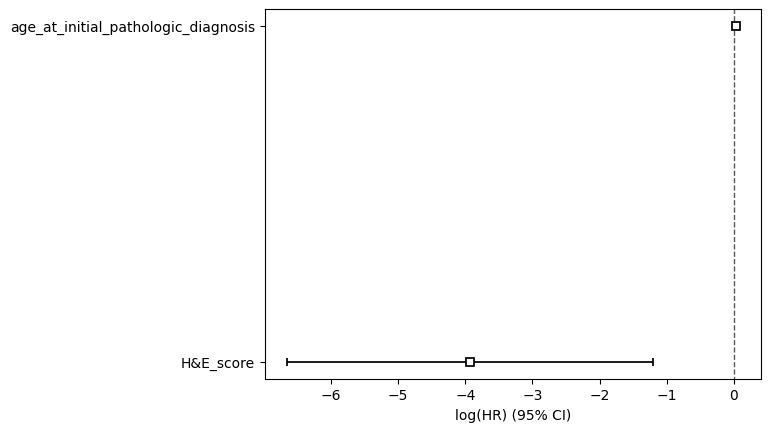

<lifelines.CoxPHFitter: fitted with 83 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 83
number of events observed = 83
   partial log-likelihood = -283.13
         time fit was run = 2023-11-30 06:36:16 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.04       1.04       0.02             0.00             0.07                 1.00                 1.07
H&E_score                            -1.75       0.17       1.13            -3.97             0.47                 0.02                 1.59

                                      cmp to     z    p   -log2(p)
covariate                                                         
age_at_initial_pathologic_diagnosis     0.00  2.11 0.03       4.85
H&E_score                               0.00 -1.55 0.12       3.04
---
Concordance = 0.65
Partial AIC = 570.27
log-likelihood ratio test = 7.52 on 2 df
-log2(p) of ll-ratio test = 5.42

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.036644   1.037323  0.017347   
H&E_score                           -1.750574   0.173674  1.130986   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.002644        0.070644   
H&E_score                                 -3.967266        0.466118   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.002647             1.073199   
H&E_score                                       0.018925             1.593796   

                                     cmp to         z         p  -log2(p)  
covariate                        

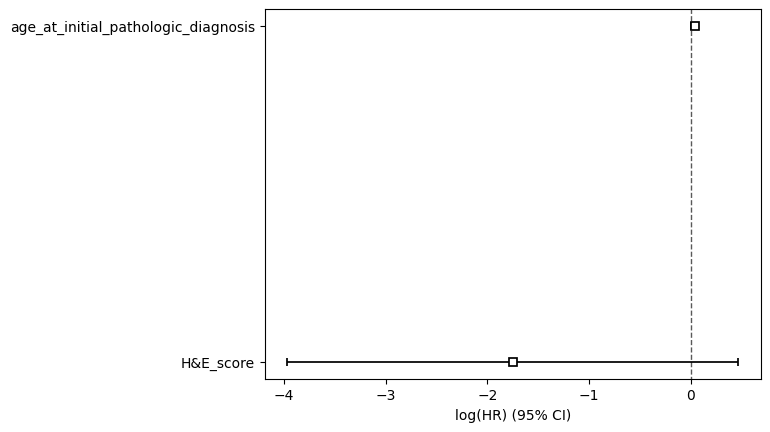

<lifelines.CoxPHFitter: fitted with 83 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 83
number of events observed = 83
   partial log-likelihood = -285.31
         time fit was run = 2023-11-30 06:36:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -2.09       0.12       1.14            -4.33             0.15                 0.01                 1.16

            cmp to     z    p   -log2(p)
covariate                               
H&E_score     0.00 -1.83 0.07       3.88
---
Concordance = 0.64
Partial AIC = 572.62
log-likelihood ratio test = 3.16 on 1 df
-log2(p) of ll-ratio test = 3.73

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -2.086774   0.124087  1.142388       -4.325813        0.152265   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z  \
covariate                                                               
H&E_score             0.013223             1.164469     0.0 -1.826678   

                  p  -log2(p)  
covariate                      
H&E_score  0.067748  3.883672  


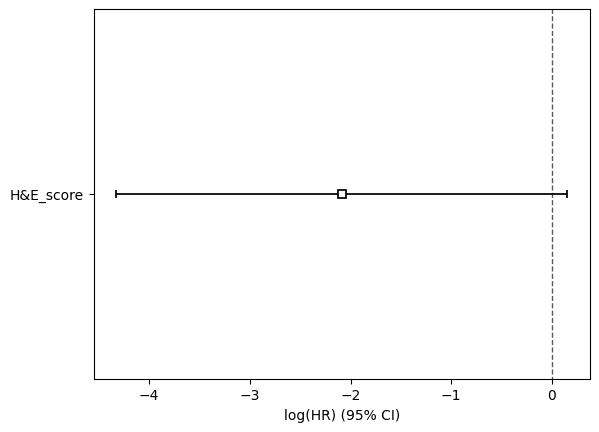

<lifelines.CoxPHFitter: fitted with 70 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 70
number of events observed = 70
   partial log-likelihood = -226.68
         time fit was run = 2023-11-30 06:36:16 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
H&E_score  -3.93       0.02       1.38            -6.63            -1.22                 0.00                 0.29

            cmp to     z      p   -log2(p)
covariate                                 
H&E_score     0.00 -2.85 <0.005       7.82
---
Concordance = 0.63
Partial AIC = 455.36
log-likelihood ratio test = 7.51 on 1 df
-log2(p) of ll-ratio test = 7.35

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
H&E_score -3.928799   0.019667  1.379872       -6.633298         -1.2243   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z        p  \
covariate                                                                       
H&E_score             0.001316             0.293963     0.0 -2.84722  0.00441   

           -log2(p)  
covariate            
H&E_score  7.824912  


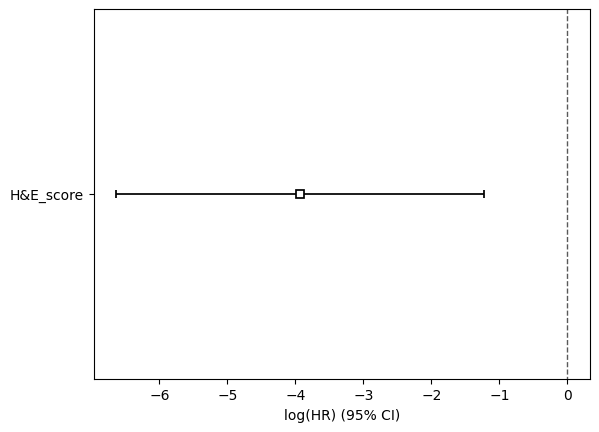

<lifelines.CoxPHFitter: fitted with 83 total observations, 0 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'OS_STATUS'
      baseline estimation = breslow
   number of observations = 83
number of events observed = 83
   partial log-likelihood = -284.28
         time fit was run = 2023-11-30 06:36:16 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.04       1.04       0.02             0.01             0.07                 1.01                 1.08

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 2.32 0.02       5.60
---
Concordance = 0.59
Partial AIC = 570.57
log-likelihood ratio test = 5.22 on 1 df
-log2(p) of ll-ratio test = 5.48

                                         coef  exp(coef)  se(coef)  \
covariate                                                            
age_at_initial_pathologic_diagnosis  0.039414   1.040201   0.01702   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis        0.006055        0.072773   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             1.006073             1.075486   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  2.315703  0.020574  5.602999  


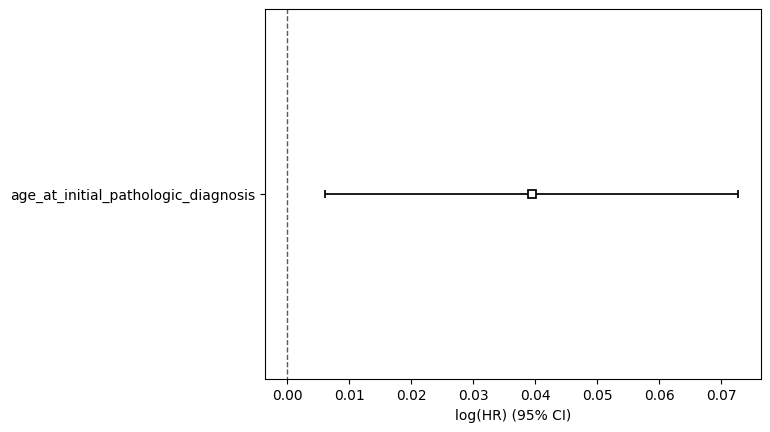

<lifelines.CoxPHFitter: fitted with 70 total observations, 0 right-censored observations>
             duration col = 'PFS_MONTHS'
                event col = 'PFS_STATUS'
      baseline estimation = breslow
   number of observations = 70
number of events observed = 70
   partial log-likelihood = -229.46
         time fit was run = 2023-11-30 06:36:16 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
age_at_initial_pathologic_diagnosis   0.03       1.03       0.02            -0.01             0.06                 0.99                 1.07

                                      cmp to    z    p   -log2(p)
covariate                                                        
age_at_initial_pathologic_diagnosis     0.00 1.42 0.16       2.67
---
Concordance = 0.53
Partial AIC = 460.92
log-likelihood ratio test = 1.96 on 1 df
-log2(p) of ll-ratio test = 2.63

                                        coef  exp(coef)  se(coef)  \
covariate                                                           
age_at_initial_pathologic_diagnosis  0.02683   1.027193  0.018951   

                                     coef lower 95%  coef upper 95%  \
covariate                                                             
age_at_initial_pathologic_diagnosis       -0.010314        0.063974   

                                     exp(coef) lower 95%  exp(coef) upper 95%  \
covariate                                                                       
age_at_initial_pathologic_diagnosis             0.989739             1.066065   

                                     cmp to         z         p  -log2(p)  
covariate                                                                  
age_at_initial_pathologic_diagnosis     0.0  1.415732  0.156854  2.672505  


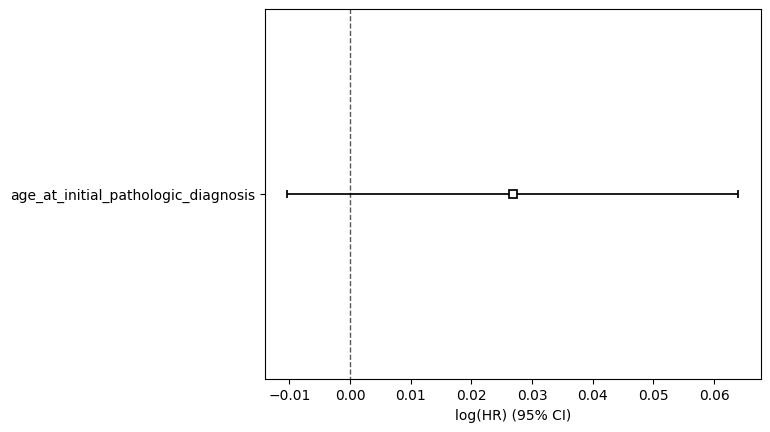

(<lifelines.CoxPHFitter: fitted with 166 total observations, 0 right-censored observations>,
 <lifelines.CoxPHFitter: fitted with 140 total observations, 0 right-censored observations>)

In [29]:
evaluation_func.model_performance(result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60], result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60], train_cox_pfs, train_cox_os)

59.0


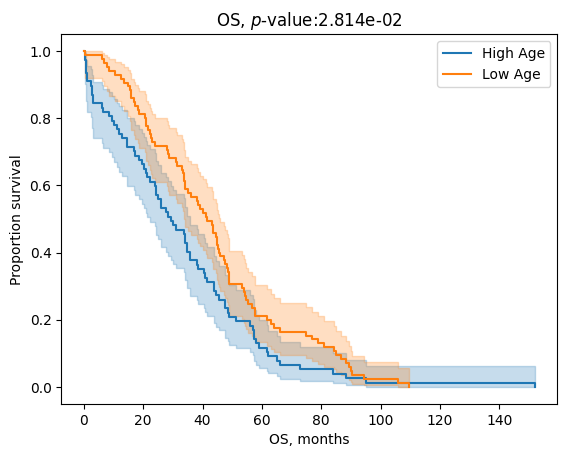

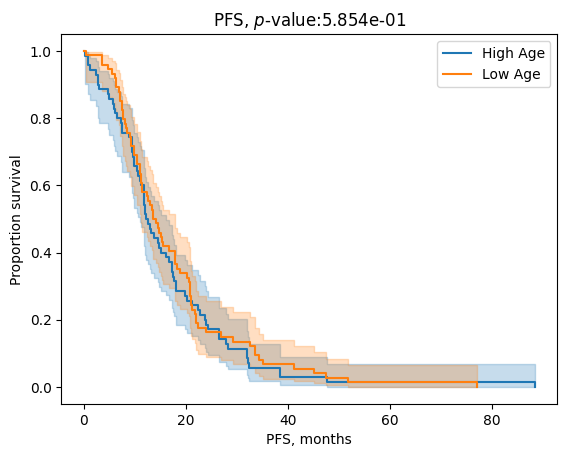

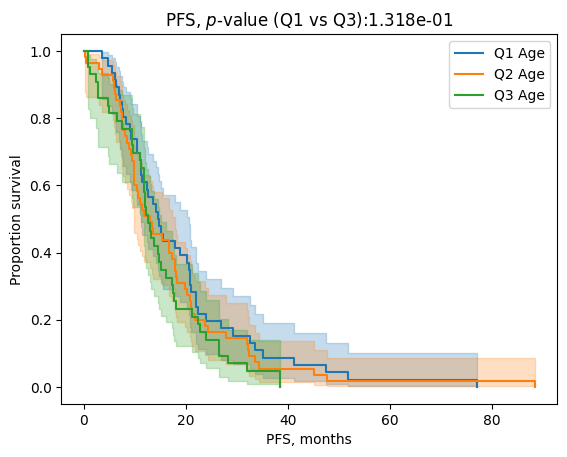

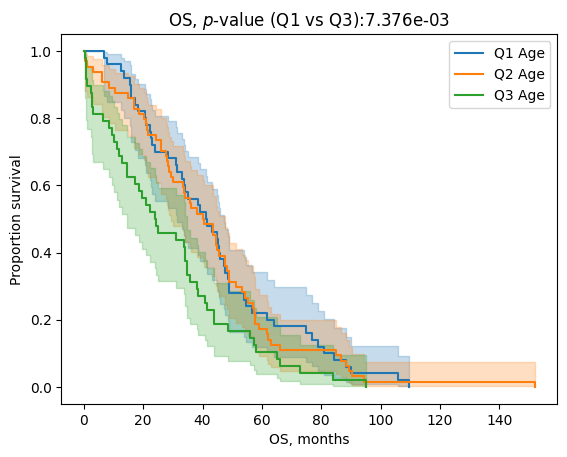

In [30]:
evaluation_func.kmplots(result_score_os_clinical,result_score_pfs_clinical,'age_at_initial_pathologic_diagnosis')

70.0


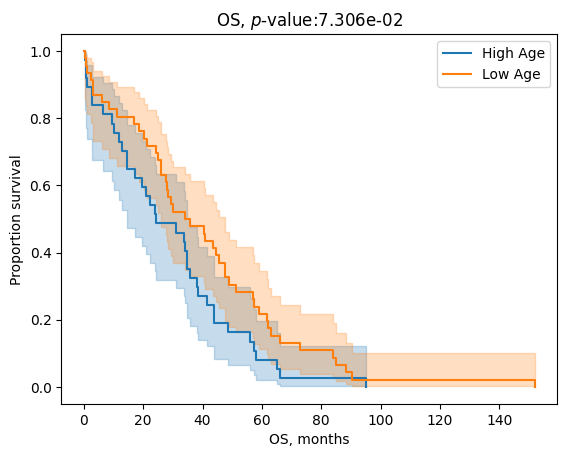

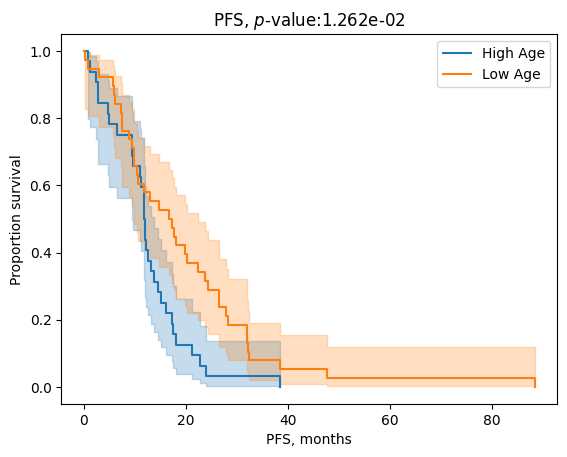

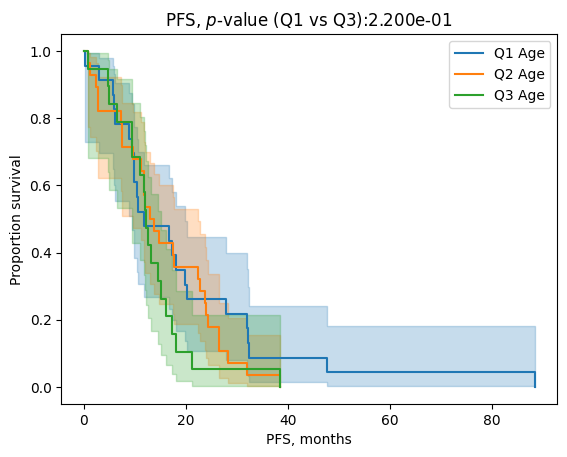

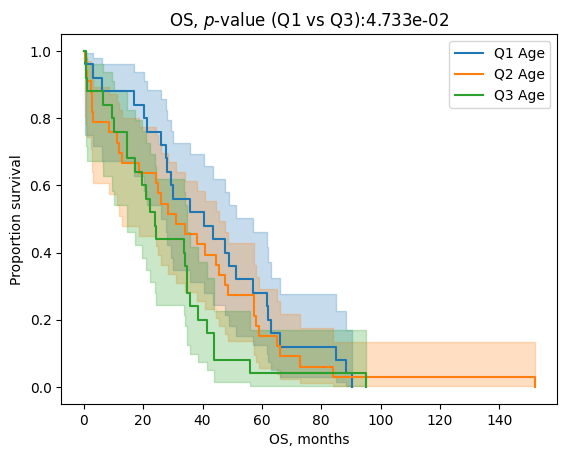

In [31]:
evaluation_func.kmplots(result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'age_at_initial_pathologic_diagnosis')

0.594153356552124


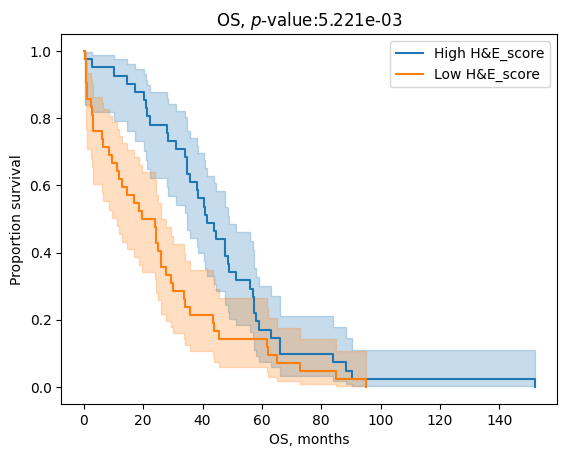

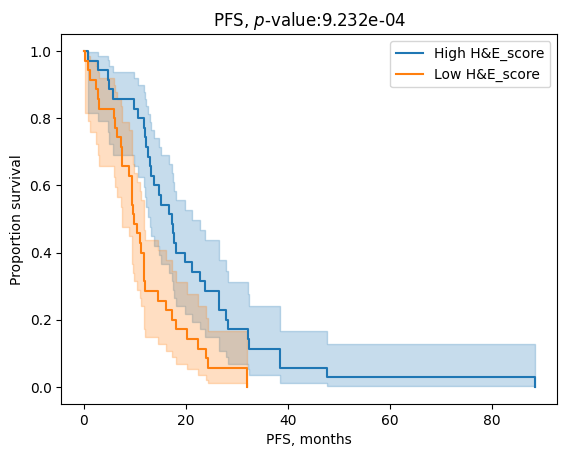

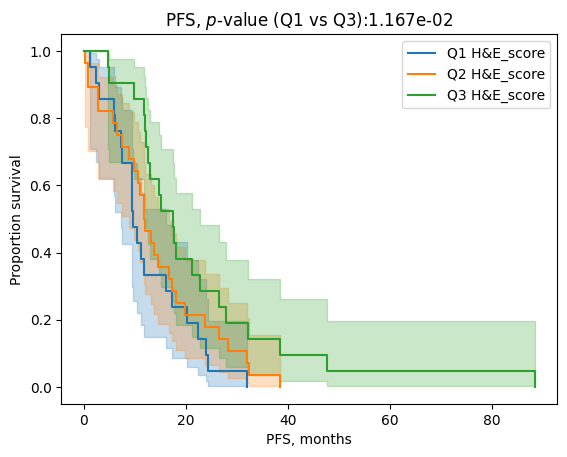

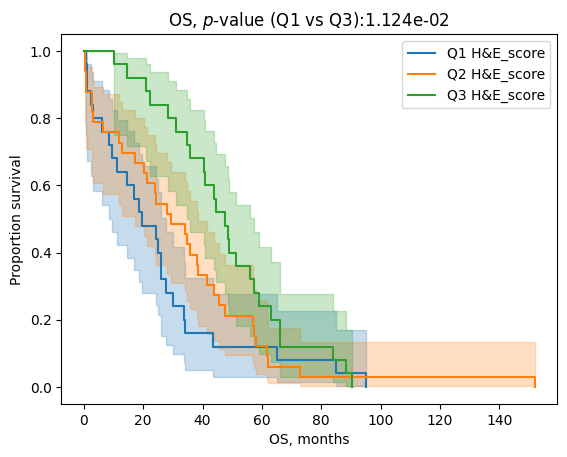

In [32]:
evaluation_func.kmplots(result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'H&E_score')

0.972092925685399


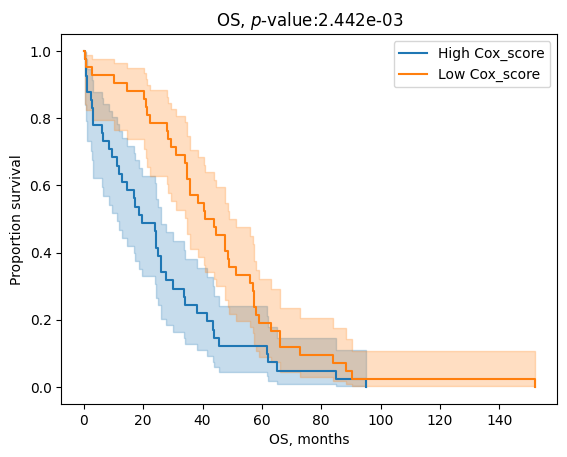

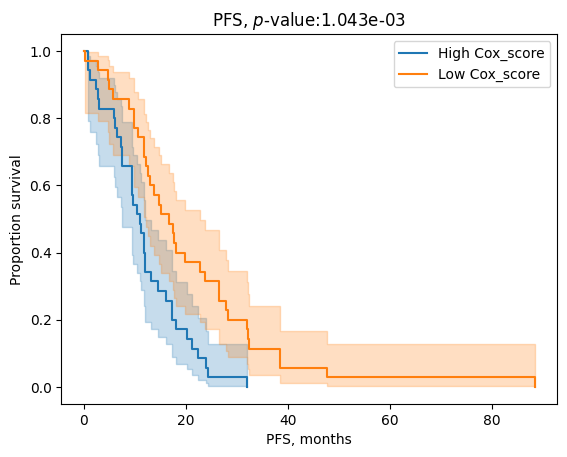

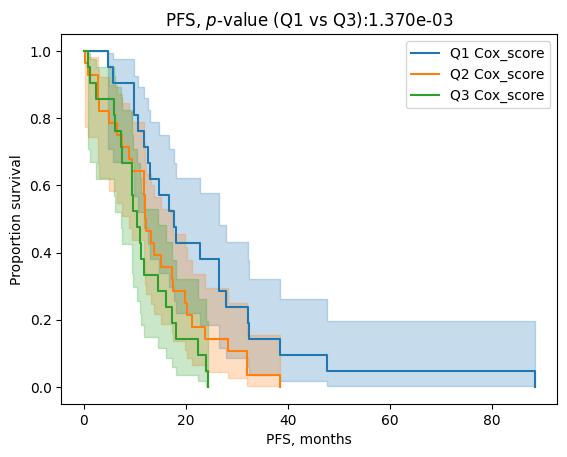

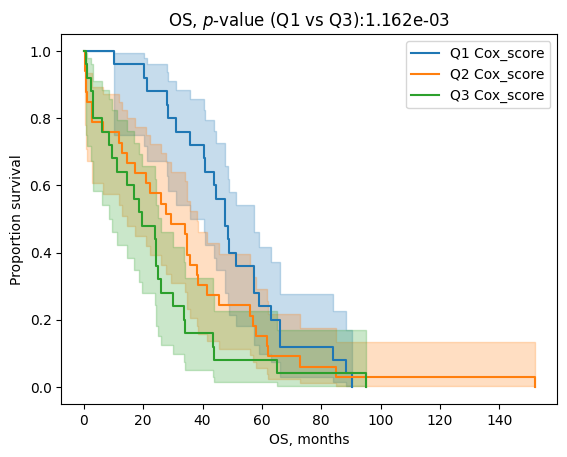

In [39]:
evaluation_func.kmplots(result_score_os_clinical[result_score_os_clinical['age_at_initial_pathologic_diagnosis']>=60],result_score_pfs_clinical[result_score_pfs_clinical['age_at_initial_pathologic_diagnosis']>=60],'Cox_score')

# Visualize attention

['../Data/707a4b6f-9706-4eed-b17c-61510a72bf54/TCGA-23-1117-01A-02-BS2.3fdc6214-2606-447c-b91d-f00036594866.svs-1.jpg'] [0]


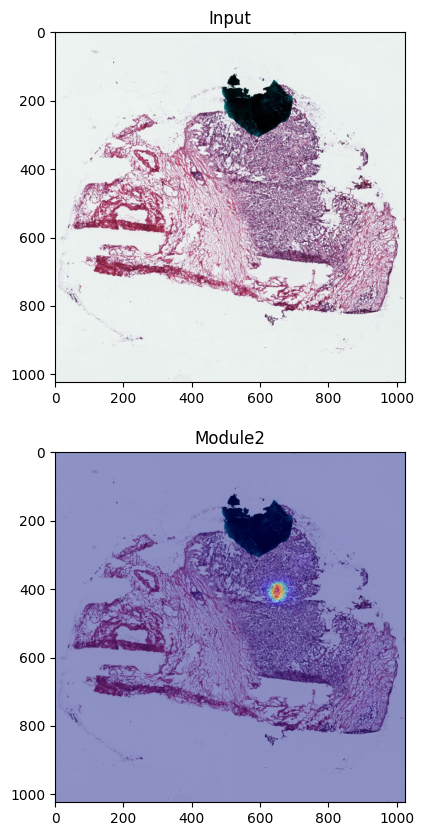

In [37]:
model_path_0 = folder + "/0/" + os.listdir(folder+'/0')[-1]

i=15
print([X_train[i]], [y_train.iloc[i]])
visualize_dataset = Dataset.MyData_test([X_train[i]], [y_train.iloc[i]])
visualize_dataloader = DataLoader(visualize_dataset,batch_size=1,shuffle=False)

evaluation_func.attention_visualization(model_path_0, visualize_dataloader)